In [1]:
import pandas as pd
import numpy as np# nan 검사 math.isnan() or numpy
import math
import random
import os
import gc

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.semi_supervised import SelfTrainingClassifier,LabelPropagation,LabelSpreading
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import log_loss

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

## Data Summary

        ID : 샘플 고유 id
        항공편 운항 관련 정보
        Month: 해당 항공편의 출발 월
        Day_of_Month: Month에 해당하는 월의 날짜
        Estimated_Departure_Time: 전산 시스템을 바탕으로 측정된 비행기의 출발 시간 (HH:MM 형식) // 일부없음
        Estimated_Arrival_Time: 전산 시스템을 바탕으로 측정된 비행기의 도착 시간 (HH:MM 형식) // 일부없음
        Cancelled: 해당 항공편의 취소 여부 (0: 취소되지 않음, 1: 취소됨) // only 0
        Diverted: 해당 항공편의 경유 여부 (0: 취소되지 않음, 1: 취소됨) // only 0
        Origin_Airport: 해당 항공편 출발 공항의 고유 코드 (IATA 공항 코드)
        Origin_Airport_ID: 해당 항공편 출발 공항의 고유 ID (US DOT ID)
        Origin_State: 해당 항공편 출발 공항이 위치한 주의 이름 // 일부없음
        Destination_Airport: 해당 항공편 도착 공항의 고유 코드 (IATA 공항 코드)
        Destination_Airport_ID: 해당 항공편 도착 공항의 고유 ID (US DOT ID)
        Destination_State: 해당 항공편 도착 공항이 위치한 주의 이름 // 일부없음
        *Distance: 출발 공항과 도착 공항 사이의 거리 (mile 단위)
        *Airline: 해당 항공편을 운항하는 항공사 // 일부없음
        Carrier_Code(IATA): 해당 항공편을 운항하는 항공사의 고유 코드 // 일부없음
        (IATA 공항 코드, 단 다른 항공사가 같은 코드를 보유할 수도 있음)
        Carrier_ID(DOT): 해당 항공편을 운항하는 항공사의 고유 ID (US DOT ID) // 일부없음
        Tail_Number: 해당 항공편을 운항하는 항공기의 고유 등록번호
        Delay: 항공편 지연 여부 (Not_Delayed, Delayed)
        예측해야 하는 타깃
        다수의 데이터에 레이블이 존재하지 않음
        준지도학습을 통해 레이블링 가능

        - model input columns list
                ID,Momth,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport_ID,Destination_Airport_ID,  Distance,Carrier_ID(DOT),Tail_Number,Delay

In [112]:
# dataPath = '~/dacon/delay_airline/'#mac
dataPath = r'C:\Users\wjswp\Dacon\Delay_Airline\data\\' #desktop
Train_data = pd.read_csv(dataPath+'train.csv')
Train_data.head()

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,TRAIN_000000,4,15,NaN,NaN,0,0,OKC,13851,Oklahoma,HOU,12191,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,NaN
1,TRAIN_000001,8,15,740.0,1024.0,0,0,ORD,13930,Illinois,SLC,14869,Utah,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,NaN
2,TRAIN_000002,9,6,1610.0,1805.0,0,0,CLT,11057,North Carolina,LGA,12953,New York,544.0,American Airlines Inc.,AA,19805.0,N103US,NaN
3,TRAIN_000003,7,10,905.0,1735.0,0,0,LAX,12892,California,EWR,11618,New Jersey,2454.0,United Air Lines Inc.,UA,NaN,N595UA,NaN
4,TRAIN_000004,1,11,900.0,1019.0,0,0,SFO,14771,California,ACV,10157,California,250.0,SkyWest Airlines Inc.,UA,20304.0,N161SY,NaN


In [3]:
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Month                     1000000 non-null  int64  
 2   Day_of_Month              1000000 non-null  int64  
 3   Estimated_Departure_Time  890981 non-null   float64
 4   Estimated_Arrival_Time    890960 non-null   float64
 5   Cancelled                 1000000 non-null  int64  
 6   Diverted                  1000000 non-null  int64  
 7   Origin_Airport            1000000 non-null  object 
 8   Origin_Airport_ID         1000000 non-null  int64  
 9   Origin_State              890985 non-null   object 
 10  Destination_Airport       1000000 non-null  object 
 11  Destination_Airport_ID    1000000 non-null  int64  
 12  Destination_State         890921 non-null   object 
 13  Distance                  10

In [4]:
Train_data.describe() # ploting list index 1,2 // 3,4,13

,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport_ID,Destination_Airport_ID,Distance,Carrier_ID(DOT)
count,1000000.000000,1000000.000000,890981.000000,890960.000000,1000000.0,1000000.0,1000000.000000,1000000.000000,1000000.000000,891003.000000
mean,6.945156,15.764842,1341.153019,1493.295934,0.0,0.0,12696.278484,12701.813986,784.078499,19997.388093
std,3.462506,8.763515,489.814011,520.803494,0.0,0.0,1514.938441,1515.213044,590.790469,404.268639
min,1.000000,1.000000,1.000000,1.000000,0.0,0.0,10135.000000,10135.000000,16.000000,19393.000000
25%,4.000000,8.000000,925.000000,1105.000000,0.0,0.0,11292.000000,11292.000000,350.000000,19790.000000
50%,7.000000,16.000000,1332.000000,1524.000000,0.0,0.0,12889.000000,12889.000000,623.000000,19977.000000
75%,10.000000,23.000000,1742.000000,1924.000000,0.0,0.0,14057.000000,14057.000000,1020.000000,20378.000000
max,12.000000,31.000000,2359.000000,2400.000000,0.0,0.0,16869.000000,16869.000000,5095.000000,21171.000000


In [5]:
#departureTime 과 ArrivalTime HH-MM 형식의 date type으로 바꿔야함

### Binary col analysis

In [6]:
Train_data.Cancelled.unique(),Train_data.Diverted.unique() # 1이 없다..?

(array([0], dtype=int64), array([0], dtype=int64))

#### NaN label 들여다보기

In [7]:
print(Train_data.Delay.value_counts())
print(Train_data.shape) # 75만 row를 label inference 해야함.

Not_Delayed    210001
Delayed         45000
Name: Delay, dtype: int64
(1000000, 19)


In [8]:
Delay_data =Train_data[Train_data.Delay == 'Delayed']
Notdelay_data =Train_data[Train_data.Delay == 'Not_Delayed']

In [9]:
Notdelay_data[Notdelay_data.iloc[:,14].isnull()]

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
32,TRAIN_000032,6,20,750.0,1014.0,0,0,ORD,13930,Illinois,LEX,12945,Kentucky,323.0,NaN,UA,20366.0,N12900,Not_Delayed
56,TRAIN_000056,3,7,600.0,808.0,0,0,ALB,10257,NaN,MSP,13487,Minnesota,980.0,NaN,DL,20304.0,N832SK,Not_Delayed
112,TRAIN_000112,2,21,2020.0,2347.0,0,0,MSP,13487,Minnesota,DCA,11278,Virginia,931.0,NaN,NaN,19790.0,N324US,Not_Delayed
144,TRAIN_000144,8,22,550.0,838.0,0,0,PNS,14193,NaN,MIA,13303,Florida,530.0,NaN,AA,20398.0,N653AE,Not_Delayed
166,TRAIN_000166,11,19,1407.0,1725.0,0,0,DEN,11292,Colorado,IAH,12266,Texas,862.0,NaN,UA,19977.0,N64809,Not_Delayed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999744,TRAIN_999744,10,14,2045.0,2326.0,0,0,ORD,13930,Illinois,AUS,10423,Texas,977.0,NaN,UA,19977.0,N848UA,Not_Delayed
999745,TRAIN_999745,12,8,800.0,1137.0,0,0,PHL,14100,Pennsylvania,SFO,14771,California,2521.0,NaN,AS,19930.0,N639VA,Not_Delayed
999769,TRAIN_999769,10,17,NaN,1653.0,0,0,MSP,13487,Minnesota,BIS,10627,North Dakota,386.0,NaN,DL,20304.0,N944SW,Not_Delayed
999791,TRAIN_999791,9,8,1305.0,1605.0,0,0,DEN,11292,Colorado,DAL,11259,Texas,651.0,NaN,NaN,19393.0,N218WN,Not_Delayed


#### origin airport col

In [10]:
'''
출발항공편 공항 기준 딜레이 안되는 카운팅
'''
origin_group = Notdelay_data.groupby(Notdelay_data['Origin_Airport'])['Delay'].count()
origin_group

Origin_Airport
ABE    149
ABI     39
ABQ    828
ABR     15
ABY     30
      ... 
XNA    384
XWA      4
YAK     28
YKM     36
YUM     41
Name: Delay, Length: 374, dtype: int64

In [11]:
'''
출발항공편 공항 기준 딜레이 카운팅
'''
origin_delaygroup = Delay_data.groupby(Delay_data['Origin_Airport'])['Delay'].count()
origin_delaygroup

Origin_Airport
ABE     33
ABI      8
ABQ    142
ABR      5
ABY      2
      ... 
XNA     63
XWA      3
YAK      3
YKM      8
YUM      4
Name: Delay, Length: 361, dtype: int64

In [12]:
delay_rate = origin_delaygroup / (origin_delaygroup + origin_group) 
delay_rate

Origin_Airport
ABE    0.181319
ABI    0.170213
ABQ    0.146392
ABR    0.250000
ABY    0.062500
         ...   
XNA    0.140940
XWA    0.428571
YAK    0.096774
YKM    0.181818
YUM    0.088889
Name: Delay, Length: 374, dtype: float64

<AxesSubplot: xlabel='Origin_Airport'>

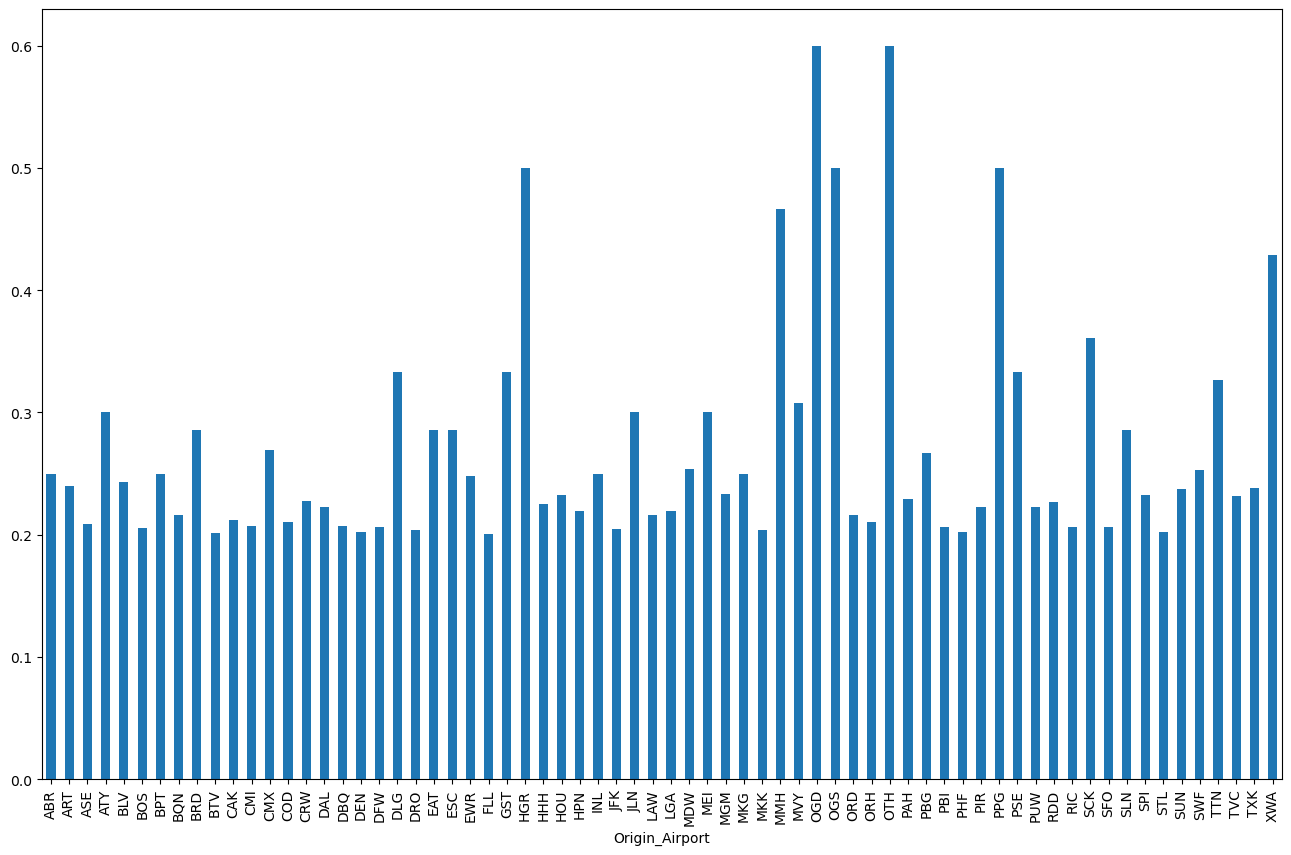

In [13]:
delay_rate[delay_rate > 0.2].plot(kind='bar',figsize=[16,10])

In [14]:
null_data =Train_data[Train_data.Delay.isnull()]
null_data.head()

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,TRAIN_000000,4,15,NaN,NaN,0,0,OKC,13851,Oklahoma,HOU,12191,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,NaN
1,TRAIN_000001,8,15,740.0,1024.0,0,0,ORD,13930,Illinois,SLC,14869,Utah,1250.0,SkyWest Airlines Inc.,UA,20304.0,N125SY,NaN
2,TRAIN_000002,9,6,1610.0,1805.0,0,0,CLT,11057,North Carolina,LGA,12953,New York,544.0,American Airlines Inc.,AA,19805.0,N103US,NaN
3,TRAIN_000003,7,10,905.0,1735.0,0,0,LAX,12892,California,EWR,11618,New Jersey,2454.0,United Air Lines Inc.,UA,NaN,N595UA,NaN
4,TRAIN_000004,1,11,900.0,1019.0,0,0,SFO,14771,California,ACV,10157,California,250.0,SkyWest Airlines Inc.,UA,20304.0,N161SY,NaN


In [15]:
null_data[null_data.Origin_Airport=='SJT']

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
13450,TRAIN_013450,10,27,508.0,612.0,0,0,SJT,14842,NaN,DFW,11298,Texas,229.0,Envoy Air,AA,20398.0,N693AE,NaN
47605,TRAIN_047605,10,11,800.0,NaN,0,0,SJT,14842,Texas,DFW,11298,Texas,229.0,Envoy Air,AA,20398.0,N856AE,NaN
62635,TRAIN_062635,8,13,1420.0,1528.0,0,0,SJT,14842,Texas,DFW,11298,Texas,229.0,Envoy Air,AA,20398.0,N852AE,NaN
77411,TRAIN_077411,3,10,1840.0,1949.0,0,0,SJT,14842,Texas,DFW,11298,Texas,229.0,Envoy Air,AA,NaN,N820AE,NaN
77545,TRAIN_077545,10,23,500.0,608.0,0,0,SJT,14842,NaN,DFW,11298,Texas,229.0,Envoy Air,AA,20398.0,N833AE,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979794,TRAIN_979794,10,2,506.0,612.0,0,0,SJT,14842,Texas,DFW,11298,Texas,229.0,Envoy Air,AA,20398.0,N831AE,NaN
980024,TRAIN_980024,8,27,1814.0,1921.0,0,0,SJT,14842,Texas,DFW,11298,Texas,229.0,Envoy Air,AA,20398.0,N821AE,NaN
982081,TRAIN_982081,5,15,1422.0,1529.0,0,0,SJT,14842,Texas,DFW,11298,Texas,229.0,Envoy Air,AA,20398.0,N816AE,NaN
991791,TRAIN_991791,9,21,1434.0,1544.0,0,0,SJT,14842,Texas,DFW,11298,Texas,229.0,Envoy Air,AA,20398.0,N852AE,NaN


#### distance 비교

In [16]:
Delay_data.Distance.describe() , Notdelay_data.Distance.describe()  # 평균 40mile의 차이가 유의미할까?

(count    45000.000000
 mean       818.448511
 std        601.474299
 min         31.000000
 25%        370.000000
 50%        663.000000
 75%       1060.000000
 max       5095.000000
 Name: Distance, dtype: float64,
 count    210001.000000
 mean        771.699697
 std         586.277088
 min          16.000000
 25%         343.000000
 50%         607.000000
 75%        1009.000000
 max        5095.000000
 Name: Distance, dtype: float64)

<AxesSubplot: >

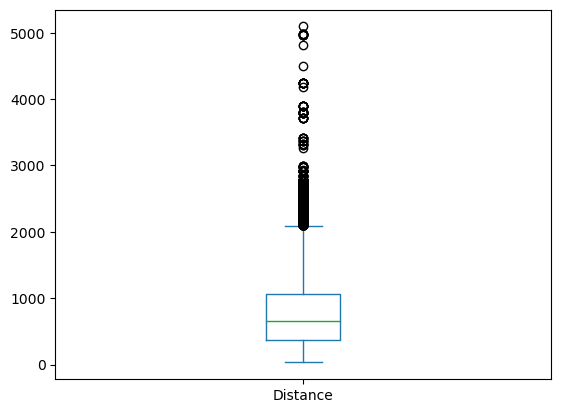

In [17]:
Delay_data.Distance.plot.box()

<AxesSubplot: >

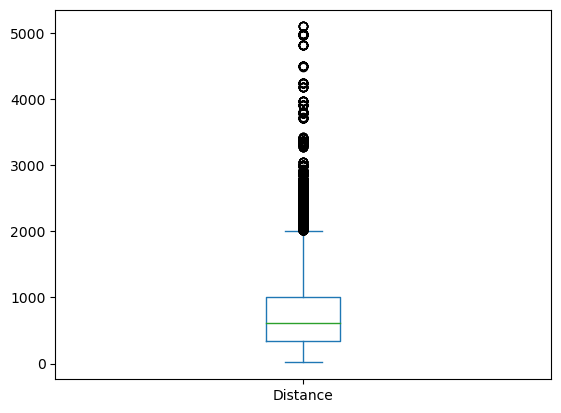

In [18]:
Notdelay_data.Distance.plot.box()

#### airline

In [19]:
Delay_data.Airline.value_counts()

Southwest Airlines Co.                       8682
American Airlines Inc.                       3929
United Air Lines Inc.                        3881
SkyWest Airlines Inc.                        3644
Delta Air Lines Inc.                         3132
JetBlue Airways                              2479
Republic Airlines                            1412
Envoy Air                                    1272
Alaska Airlines Inc.                         1188
Comair Inc.                                  1106
Mesa Airlines Inc.                           1091
Frontier Airlines Inc.                       1083
Spirit Air Lines                             1051
ExpressJet Airlines Inc.                      999
Endeavor Air Inc.                             911
Allegiant Air                                 663
Air Wisconsin Airlines Corp                   550
Trans States Airlines                         509
Horizon Air                                   494
Commutair Aka Champlain Enterprises, Inc.     464


In [20]:
Notdelay_data.Airline.value_counts()

Southwest Airlines Co.                       37462
Delta Air Lines Inc.                         20772
SkyWest Airlines Inc.                        18416
United Air Lines Inc.                        17512
American Airlines Inc.                       16941
JetBlue Airways                               7707
Republic Airlines                             7285
Alaska Airlines Inc.                          6442
Envoy Air                                     5707
Spirit Air Lines                              5386
Comair Inc.                                   5211
Mesa Airlines Inc.                            5188
Endeavor Air Inc.                             5088
ExpressJet Airlines Inc.                      4078
Frontier Airlines Inc.                        3172
Horizon Air                                   2978
Air Wisconsin Airlines Corp                   2919
Allegiant Air                                 2771
Hawaiian Airlines Inc.                        2709
Capital Cargo International    

In [21]:
airline_delaytop = Delay_data.Airline.value_counts()/(Delay_data.Airline.value_counts() + Notdelay_data.Airline.value_counts())
airline_delaytop


Air Wisconsin Airlines Corp                  0.158547
Alaska Airlines Inc.                         0.155701
Allegiant Air                                0.193069
American Airlines Inc.                       0.188261
Cape Air                                     0.107143
Capital Cargo International                  0.160259
Comair Inc.                                  0.175083
Commutair Aka Champlain Enterprises, Inc.    0.284663
Compass Airlines                             0.179654
Delta Air Lines Inc.                         0.131024
Empire Airlines Inc.                         0.126623
Endeavor Air Inc.                            0.151859
Envoy Air                                    0.182261
ExpressJet Airlines Inc.                     0.196770
Frontier Airlines Inc.                       0.254524
GoJet Airlines, LLC d/b/a United Express     0.177959
Hawaiian Airlines Inc.                       0.087572
Horizon Air                                  0.142281
JetBlue Airways             

<AxesSubplot: >

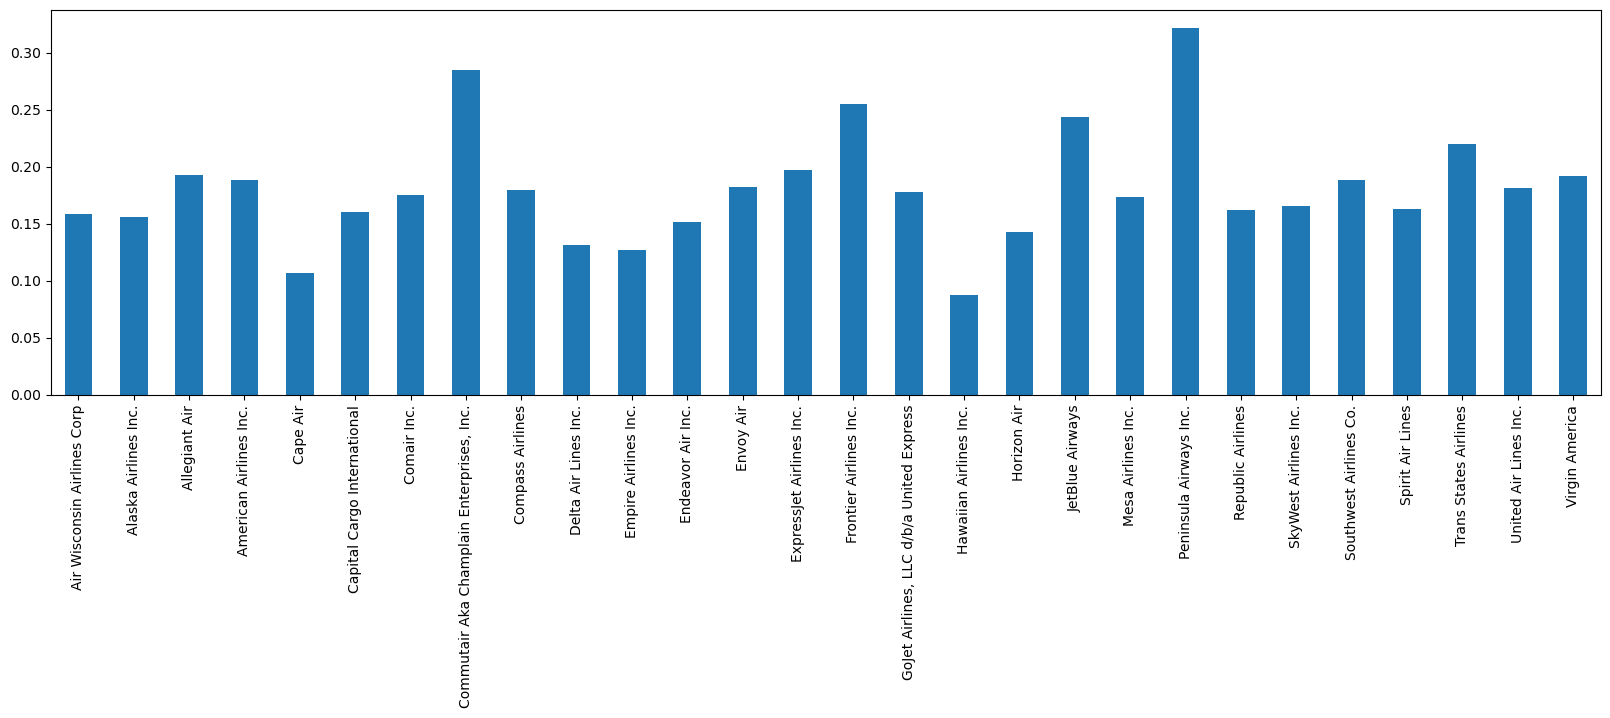

In [22]:
airline_delaytop.plot(kind='bar',figsize=[20,5])

#### date

In [117]:
Train_data['Estimated_Arrival_Time'].fillna(-1)
Train_data['Estimated_Departure_Time'].fillna(-1)



0           -1.0
1          740.0
2         1610.0
3          905.0
4          900.0
           ...  
999995     936.0
999996     920.0
999997     800.0
999998    1613.0
999999    1800.0
Name: Estimated_Departure_Time, Length: 1000000, dtype: float64

In [133]:
# Train_data.loc['149939','Estimated_Arrival_Time']
# Train_data.loc[149939,'Estimated_Arrival_Time'] = '0000'
# datetime.strptime(Train_data.loc[149939,'Estimated_Arrival_Time'],'%H%M')

datetime.datetime(1900, 1, 1, 0, 0)

In [134]:
from datetime import datetime
def change_time(colname,ch1,ch2):
    idx = Train_data[Train_data[colname].notnull()].index
    n = 0
    for i in idx:
        try:
            Train_data.loc[i,colname] = str(int(Train_data.loc[i,colname]))
            if Train_data.loc[i,colname] == '2400':
                Train_data.loc[i,colname] = '0000'
            if len(Train_data.loc[i,colname]) < 4:
                n = 4 -len(Train_data.loc[i,colname])
                Train_data.loc[i,colname] = n*'0'+ Train_data.loc[i,colname]
            Train_data.loc[i,ch1] = datetime.strptime(Train_data.loc[i,colname],'%H%M').hour
            Train_data.loc[i,ch2] = datetime.strptime(Train_data.loc[i,colname],'%H%M').minute
        except:
            print(Train_data.loc[i,colname])
            pass
change_time('Estimated_Arrival_Time','Estimated_Arrival_hour','Estimated_Arrival_minute')
change_time('Estimated_Departure_Time','Estimated_Departure_hour','Estimated_Departure_minute')

In [139]:
Train_data = Train_data.drop(columns=[
    'Estimated_Departure_Time','Estimated_Arrival_Time','Cancelled','Diverted'
])
Train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   ID                          1000000 non-null  object 
 1   Month                       1000000 non-null  int64  
 2   Day_of_Month                1000000 non-null  int64  
 3   Origin_Airport              1000000 non-null  object 
 4   Origin_Airport_ID           1000000 non-null  int64  
 5   Origin_State                890985 non-null   object 
 6   Destination_Airport         1000000 non-null  object 
 7   Destination_Airport_ID      1000000 non-null  int64  
 8   Destination_State           890921 non-null   object 
 9   Distance                    1000000 non-null  float64
 10  Airline                     891080 non-null   object 
 11  Carrier_Code(IATA)          891010 non-null   object 
 12  Carrier_ID(DOT)             891003 non-null   float64
 13

In [144]:
Train_data = Train_data[[
    'ID', 'Month', 'Day_of_Month', 'Estimated_Departure_hour',
       'Estimated_Departure_minute', 'Estimated_Arrival_hour',
       'Estimated_Arrival_minute', 'Origin_Airport', 'Origin_Airport_ID',
       'Origin_State', 'Destination_Airport', 'Destination_Airport_ID',
       'Destination_State', 'Distance', 'Airline', 'Carrier_Code(IATA)',
       'Carrier_ID(DOT)', 'Tail_Number', 'Delay'
]]

In [135]:
# from datetime import datetime
# Train_data['Estimated_Arrival_Time'] = Train_data['Estimated_Arrival_Time'].astype(str)
# idx = Train_data[Train_data.Estimated_Arrival_Time != 'nan'].index
# for i in idx:
#     print(i)
#     Train_data.loc[i,'Estimated_Arrival_hour'] = datetime.strptime(Train_data.loc[i,'Estimated_Arrival_Time'],'%H%M').hour
#     Train_data.loc[i,'Estimated_Arrival_minute'] = datetime.strptime(Train_data.loc[i,'Estimated_Arrival_Time'],'%H%M').minute

# Train_data['Estimated_Departure_Time'] = Train_data['Estimated_Departure_Time'].astype(str)
# idx = Train_data[Train_data.Estimated_Departure_Time != 'nan'].index
# for i in idx:
#     Train_data.loc[i,'Estimated_Departure_hour'] = datetime.strptime(Train_data.loc[i,'Estimated_Departure_Time'],'%H%M').hour
#     Train_data.loc[i,'Estimated_Departure_minute'] = datetime.strptime(Train_data.loc[i,'Estimated_Departure_Time'],'%H%M').minute

#### carrier None fill
    IATA와 ID가 동일하면 항공사(airline)를 알 수 있다.
    

##### ID의 null 없애기를 최우선으로
    생각해보니 머신러닝은 문자열을 다시 원-핫이나 레이블 인코딩을 해줘야하니, ID값을 기준으로 모델이 학습하도록 하고 나머지는 컬럼drop하는게 좋지 않을까?

##### 항공사 3columns가 다 없는 경우
    Tail_Number로 fill 가능

In [145]:
'''
하나의 항공사 ID 값과 항공사 이름이 유니크(1:1매칭)할 경우 NaN 처리
'''
for i in Train_data['Carrier_ID(DOT)'].dropna().unique():
    air = Train_data.loc[Train_data['Carrier_ID(DOT)']==i,'Airline'].dropna().unique()
    if len(air) ==1:
        Train_data.loc[Train_data['Carrier_ID(DOT)']==i,'Airline'] = air[0]
        
for i in Train_data['Airline'].dropna().unique():
    air = Train_data.loc[Train_data['Airline']==i,'Carrier_ID(DOT)'].dropna().unique()
    if len(air) ==1:
        Train_data.loc[Train_data['Airline']==i,'Carrier_ID(DOT)'] = air[0]

In [146]:

'''
2차 처리
항공사 ID 값이 여전히 NaN 인 row들의 tail number를 가져와서 tail number로 인덱싱 했을때 ID,name,IATA값이 유니크한 경우 NaN값들에 적용하기
'''
for i in Train_data.loc[Train_data['Carrier_ID(DOT)'].isnull(),'Tail_Number'].unique():
    air = Train_data.loc[Train_data['Tail_Number']==i,'Carrier_ID(DOT)'].dropna().unique()
    if len(air) == 1:
        Train_data.loc[Train_data['Tail_Number']==i,'Carrier_ID(DOT)'] = air[0]

In [147]:
for i in Train_data.loc[Train_data['Airline'].isnull(),'Tail_Number'].unique():
    air = Train_data.loc[Train_data['Tail_Number']==i,'Airline'].dropna().unique()
    if len(air) == 1:
        Train_data.loc[Train_data['Tail_Number']==i,'Airline'] = air[0]

In [148]:
for i in Train_data.loc[Train_data['Carrier_Code(IATA)'].isnull(),'Tail_Number'].unique():
    air = Train_data.loc[Train_data['Tail_Number']==i,'Carrier_Code(IATA)'].dropna().unique()
    if len(air) == 1:
        Train_data.loc[Train_data['Tail_Number']==i,'Carrier_Code(IATA)'] = air[0]

In [149]:
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   ID                          1000000 non-null  object 
 1   Month                       1000000 non-null  int64  
 2   Day_of_Month                1000000 non-null  int64  
 3   Estimated_Departure_hour    890981 non-null   float64
 4   Estimated_Departure_minute  890981 non-null   float64
 5   Estimated_Arrival_hour      890960 non-null   float64
 6   Estimated_Arrival_minute    890960 non-null   float64
 7   Origin_Airport              1000000 non-null  object 
 8   Origin_Airport_ID           1000000 non-null  int64  
 9   Origin_State                890985 non-null   object 
 10  Destination_Airport         1000000 non-null  object 
 11  Destination_Airport_ID      1000000 non-null  int64  
 12  Destination_State           890921 non-null   object 
 13

In [29]:
# for문으로 nan 검출하려면 math.isnan()
# for i in Train_data['Carrier_ID(DOT)'].unique():
#     if math.isnan(i) == False: 
#         print(i)

In [30]:
# def standardID_fill(col):
#     if math.isnan(col['Carrier_ID(DOT)']) == False:
#         airline = Train_data[carrierId == col['Carrier_ID(DOT)']].Airline.unique()[0]
#     else:
#         airline = col.Airline
#     return airline

# Train_data['Airline'] = Train_data.apply(standardID_fill,axis=1)

#### 거리가 NaN일 경우
    Date type으로 변환한 후에 !!! (시간 계산이 달라질 수 있음.)
    같은 거리일 경우에도 스케줄 시간(도착시간-출발시간)이 다를 수 있음. 따라서 값이 있는 다른 컬럼들의 평균 값(int변환)에 따라서 값 지정

    -> 다만 시각이 둘 다 없는 경우 어떤형태로 작성할지 고민.


In [31]:
nan_depart = Train_data['Estimated_Departure_Time'].isnull()
nan_arrival = Train_data['Estimated_Arrival_Time'].isnull()

In [32]:
Train_data[nan_depart & nan_arrival]

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Cancelled,Diverted,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,TRAIN_000000,4,15,NaN,NaN,0,0,OKC,13851,Oklahoma,HOU,12191,Texas,419.0,Southwest Airlines Co.,WN,19393.0,N7858A,NaN
109,TRAIN_000109,3,29,NaN,NaN,0,0,PDX,14057,Oregon,DEN,11292,Colorado,991.0,Southwest Airlines Co.,WN,19393.0,N499WN,NaN
277,TRAIN_000277,8,9,NaN,NaN,0,0,MKE,13342,Wisconsin,IAH,12266,Texas,984.0,Mesa Airlines Inc.,UA,20378.0,N88335,NaN
435,TRAIN_000435,9,12,NaN,NaN,0,0,OAK,13796,California,ORD,13930,Illinois,1836.0,Spirit Air Lines,NK,20416.0,N618NK,NaN
437,TRAIN_000437,7,12,NaN,NaN,0,0,HOU,12191,Texas,MSY,13495,NaN,302.0,Southwest Airlines Co.,WN,19393.0,N265WN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999771,TRAIN_999771,7,10,NaN,NaN,0,0,FLL,11697,Florida,ORD,13930,Illinois,1182.0,JetBlue Airways,B6,20409.0,N529JB,NaN
999777,TRAIN_999777,9,27,NaN,NaN,0,0,STS,15023,California,SEA,14747,Washington,618.0,SkyWest Airlines Inc.,AS,20304.0,N403SY,Delayed
999815,TRAIN_999815,12,1,NaN,NaN,0,0,SEA,14747,Washington,BOI,10713,Idaho,399.0,Horizon Air,AS,19687.0,N401QX,NaN
999911,TRAIN_999911,7,14,NaN,NaN,0,0,HOU,12191,Texas,DEN,11292,Colorado,883.0,Southwest Airlines Co.,WN,19393.0,N935WN,NaN


In [33]:
origin = Train_data['Origin_Airport_ID'] == 13851
destination = Train_data['Destination_Airport_ID'] == 12191

In [34]:
test = Train_data[origin & destination]

In [35]:
test['estimated_mean'] = test['Estimated_Arrival_Time'] - test['Estimated_Departure_Time']

C:\Users\wjswp\AppData\Local\Temp\ipykernel_20364\4183909609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['estimated_mean'] = test['Estimated_Arrival_Time'] - test['Estimated_Departure_Time']


In [36]:
test.estimated_mean.describe()

count    163.000000
mean     147.576687
std       20.885903
min      115.000000
25%      125.000000
50%      165.000000
75%      165.000000
max      175.000000
Name: estimated_mean, dtype: float64

#### 나머지 결측치 필터링으로 채우기

In [164]:
#IATA가 이상하게 덮혀버리는 문제 있을때 잘못 덮인 row 초기화
dataPath = r'C:\Users\wjswp\Dacon\Delay_Airline\data\\' #desktop
data = pd.read_csv(dataPath+'train.csv')
null_d = Train_data[Train_data['Carrier_ID(DOT)'].isnull()]
for i in null_d.index:
    Train_data.loc[i,'Carrier_Code(IATA)'] = data.loc[i,'Carrier_Code(IATA)']

In [151]:
'''
3차 처리 
2차 처리에서 안된 것 중 출발,도착항공을 추가로 인덱싱하면 유니크한 값이 나올 수 있음을 일부 확인. 해당 부분을 적용하여
출발 항공, 도착 항공, tail number, iata를 기준으로 인덱싱했을 떄 유니크한 값 처리 (처음에는 도착항공까지는 넣지않고, 출발항공,tail,iata를 인덱싱기준으로 삼고 진행함)
'''
fil_lst = null_d['Tail_Number'].unique()
for tailnum in fil_lst:
    idx = null_d.loc[null_d['Tail_Number'] == tailnum,'Origin_Airport'].index
    ori_val = null_d.loc[null_d['Tail_Number'] == tailnum,'Origin_Airport'].values
    dest_val = null_d.loc[null_d['Tail_Number'] == tailnum,'Destination_Airport'].values
    iata = null_d.loc[null_d['Tail_Number'] == tailnum,'Carrier_Code(IATA)'].values
    print(tailnum)
    for n in range(len(idx)):
        try:
            airline = Train_data.loc[(Train_data['Origin_Airport'] == ori_val[n]) & (Train_data['Destination_Airport'] == dest_val[n]) & (Train_data['Tail_Number'] == tailnum) & (Train_data['Carrier_Code(IATA)'] == iata[n]),'Airline'].dropna().unique()
            print(airline)
            if len(airline) == 1:
                air_id = Train_data.loc[Train_data['Airline'] == airline[0],'Carrier_ID(DOT)'].dropna().unique().astype(int)
                Train_data.loc[idx[n],'Airline'] = airline[0]
                Train_data.loc[idx[n],'Carrier_ID(DOT)'] = air_id
        except:
            pass
        

N523AE
['Envoy Air']
['Comair Inc.']
[]
['Comair Inc.']
['Comair Inc.']
N637VA
['Virgin America']
[]
['Alaska Airlines Inc.']
['Alaska Airlines Inc.']
['Alaska Airlines Inc.']
['Alaska Airlines Inc.']
['Alaska Airlines Inc.']
[]
N12163
[]
[]
[]
N532EA
['Envoy Air']
['Envoy Air']
N621VA
[]
[]
[]
[]
N525VA
['Alaska Airlines Inc.']
[]
['Alaska Airlines Inc.']
['Alaska Airlines Inc.']
N627VA
['Alaska Airlines Inc.']
['Virgin America']
['Alaska Airlines Inc.']
['Alaska Airlines Inc.']
['Alaska Airlines Inc.']
N27190
['Commutair Aka Champlain Enterprises, Inc.']
['Commutair Aka Champlain Enterprises, Inc.']
['Commutair Aka Champlain Enterprises, Inc.']
['Commutair Aka Champlain Enterprises, Inc.']
N759EV
['SkyWest Airlines Inc.']
['SkyWest Airlines Inc.']
N750EV
[]
['SkyWest Airlines Inc.']
N641VA
['Alaska Airlines Inc.']
[]
[]
['Alaska Airlines Inc.']
['Alaska Airlines Inc.']
N364VA
['Alaska Airlines Inc.']
['Alaska Airlines Inc.']
N844VA
[]
['Alaska Airlines Inc.']
['Alaska Airlines Inc.']

In [160]:
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   ID                          1000000 non-null  object 
 1   Month                       1000000 non-null  int64  
 2   Day_of_Month                1000000 non-null  int64  
 3   Estimated_Departure_hour    890981 non-null   float64
 4   Estimated_Departure_minute  890981 non-null   float64
 5   Estimated_Arrival_hour      890960 non-null   float64
 6   Estimated_Arrival_minute    890960 non-null   float64
 7   Origin_Airport              1000000 non-null  object 
 8   Origin_Airport_ID           1000000 non-null  int64  
 9   Origin_State                890985 non-null   object 
 10  Destination_Airport         1000000 non-null  object 
 11  Destination_Airport_ID      1000000 non-null  int64  
 12  Destination_State           890921 non-null   object 
 13

In [153]:
null_d = Train_data[Train_data['Carrier_ID(DOT)'].isnull()]
fil_lst = null_d['Tail_Number'].unique()
for tailnum in fil_lst:
    idx = null_d.loc[null_d['Tail_Number'] == tailnum,'Origin_Airport'].index
    ori_val = null_d.loc[null_d['Tail_Number'] == tailnum,'Origin_Airport'].values
    dest_val = null_d.loc[null_d['Tail_Number'] == tailnum,'Destination_Airport'].values
    iata = null_d.loc[null_d['Tail_Number'] == tailnum,'Carrier_Code(IATA)'].values
    print(tailnum)
    for n in range(len(idx)):
        try:
            airline = Train_data.loc[(Train_data['Origin_Airport'] == ori_val[n]) & (Train_data['Tail_Number'] == tailnum),'Airline'].dropna().unique()
            print(idx[n],airline)
            if len(airline) == 1 :
                air_id = Train_data.loc[Train_data['Airline'] == airline[0],'Carrier_ID(DOT)'].dropna().unique().astype(int)
                uniq_iata = Train_data.loc[Train_data['Airline'] == airline[0],'Carrier_Code(IATA)'].dropna().unique()
                Train_data.loc[idx[n],'Airline'] = airline[0]
                Train_data.loc[idx[n],'Carrier_ID(DOT)'] = air_id
            if len(uniq_iata) == 1:
                Train_data.loc[idx[n],'Carrier_Code(IATA)'] = uniq_iata[0]
        except:
            pass
        

N12163
15218 ['ExpressJet Airlines Inc.']
612424 []
935739 ['ExpressJet Airlines Inc.']
N621VA
17389 ['Alaska Airlines Inc.']
482330 ['Alaska Airlines Inc.' 'Virgin America']
933082 ['Alaska Airlines Inc.']
948716 ['Virgin America' 'Alaska Airlines Inc.']
N750EV
41358 []
N844VA
44465 ['Alaska Airlines Inc.']
N923VA
46931 ['Alaska Airlines Inc.' 'Virgin America']
317497 ['Alaska Airlines Inc.' 'Virgin America']
N523AE
47564 ['Comair Inc.']
N841VA
51919 ['Alaska Airlines Inc.' 'Virgin America']
762926 ['Alaska Airlines Inc.']
N526VA
53152 ['Alaska Airlines Inc.' 'Virgin America']
N856AS
63639 ['SkyWest Airlines Inc.']
N637VA
68226 ['Alaska Airlines Inc.']
485162 ['Alaska Airlines Inc.']
N641VA
77181 ['Alaska Airlines Inc.' 'Virgin America']
85206 ['Alaska Airlines Inc.']
N607AE
85554 ['Envoy Air']
N525VA
94889 ['Alaska Airlines Inc.']
N527VA
113700 []
N285VA
114888 ['Alaska Airlines Inc.' 'Virgin America']
171762 ['Alaska Airlines Inc.' 'Virgin America']
865933 []
N655AE
117191 ['Capital

In [157]:
null_d = Train_data[Train_data['Carrier_ID(DOT)'].isnull()]
fil_lst = null_d['Tail_Number'].unique()
for tailnum in fil_lst:
    idx = null_d.loc[null_d['Tail_Number'] == tailnum,'Origin_Airport'].index
    ori_val = null_d.loc[null_d['Tail_Number'] == tailnum,'Origin_Airport'].values
    dest_val = null_d.loc[null_d['Tail_Number'] == tailnum,'Destination_Airport'].values
    iata = null_d.loc[null_d['Tail_Number'] == tailnum,'Carrier_Code(IATA)'].values
    print(tailnum)
    for n in range(len(idx)):
        try:
            airline = Train_data.loc[(Train_data['Origin_Airport'] == ori_val[n]) & (Train_data['Tail_Number'] == tailnum) & (Train_data['Carrier_Code(IATA)'] == iata[n]),'Airline'].dropna().unique()
            car_id = Train_data.loc[(Train_data['Origin_Airport'] == ori_val[n]) & (Train_data['Tail_Number'] == tailnum) & (Train_data['Carrier_Code(IATA)'] == iata[n]),'Carrier_ID(DOT)'].dropna().unique()
            print(idx[n],airline)
            if len(airline) == 1 :
                uniq_iata = Train_data.loc[Train_data['Airline'] == airline[0],'Carrier_Code(IATA)'].dropna().unique()
                Train_data.loc[idx[n],'Airline'] = airline[0]
            if len(car_id) == 1:
                car_id.astype(int)
                Train_data.loc[idx[n],'Carrier_ID(DOT)'] = car_id
            if len(uniq_iata) == 1:
                Train_data.loc[idx[n],'Carrier_Code(IATA)'] = uniq_iata[0]
        except:
            pass

N750EV
41358 []
N923VA
46931 []
317497 ['Alaska Airlines Inc.']
N841VA
51919 []
N526VA
53152 []
N641VA
77181 ['Alaska Airlines Inc.']
N527VA
113700 []
N285VA
114888 ['Alaska Airlines Inc.']
171762 []
865933 []
N628VA
139348 ['Alaska Airlines Inc.']
622786 []
N846VA
148163 ['Alaska Airlines Inc.']
537323 []
N610AE
150659 []
N529VA
167271 ['Alaska Airlines Inc.']
N909EV
167579 []
N626VA
172105 ['Virgin America']
N606AE
181506 []
N854AS
190607 ['ExpressJet Airlines Inc.' 'SkyWest Airlines Inc.']
N921VA
217252 []
449449 ['Alaska Airlines Inc.']
N195PQ
235759 ['Endeavor Air Inc.' 'ExpressJet Airlines Inc.']
N27152
242949 ['Commutair Aka Champlain Enterprises, Inc.' 'ExpressJet Airlines Inc.']
N862AS
248486 []
N361VA
261008 []
N652RS
298203 []
N678CA
299400 []
786662 []
N284VA
324010 ['Alaska Airlines Inc.']
N860AS
353215 []
N524AE
356233 []
N14168
356692 ['Commutair Aka Champlain Enterprises, Inc.' 'ExpressJet Airlines Inc.']
N871AS
359142 []
N851VA
359567 []
N867DA
382926 []
N922VA
386741 

In [161]:
null_d = Train_data[Train_data['Carrier_ID(DOT)'].isnull()]
fil_lst = null_d['Tail_Number'].unique()
for tailnum in fil_lst:
    idx = null_d.loc[null_d['Tail_Number'] == tailnum,'Origin_Airport'].index
    ori_val = null_d.loc[null_d['Tail_Number'] == tailnum,'Origin_Airport'].values
    dest_val = null_d.loc[null_d['Tail_Number'] == tailnum,'Destination_Airport'].values
    iata = null_d.loc[null_d['Tail_Number'] == tailnum,'Carrier_Code(IATA)'].values
    print(tailnum)
    for n in range(len(idx)):
        try:
            airline = Train_data.loc[(Train_data['Origin_Airport'] == ori_val[n]) & (Train_data['Tail_Number'] == tailnum) & (Train_data['Carrier_Code(IATA)'] == iata[n]),'Airline'].dropna().unique()
            car_id = Train_data.loc[(Train_data['Tail_Number'] == tailnum) & (Train_data['Carrier_Code(IATA)'] == iata[n]),'Carrier_ID(DOT)'].dropna().unique()
            print(idx[n],airline)
            if len(airline) == 1 :
                uniq_iata = Train_data.loc[Train_data['Airline'] == airline[0],'Carrier_Code(IATA)'].dropna().unique()
                Train_data.loc[idx[n],'Airline'] = airline[0]
            if len(car_id) == 1:
                car_id.astype(int)
                Train_data.loc[idx[n],'Carrier_ID(DOT)'] = car_id
            if len(uniq_iata) == 1:
                Train_data.loc[idx[n],'Carrier_Code(IATA)'] = uniq_iata[0]
        except:
            pass

N923VA
46931 []
N610AE
150659 []
N909EV
167579 []
N606AE
181506 []
N854AS
190607 []
N195PQ
235759 []
N27152
242949 []
N862AS
248486 []
N652RS
298203 []
N678CA
299400 []
786662 []
N860AS
353215 []
N524AE
356233 []
N14168
356692 []
N871AS
359142 []
N867DA
382926 []
N538CA
386969 []
887147 []
N903EV
481841 []
557580 []
619215 []
N533AE
498370 []
N23139
565234 []
N619AE
567702 []
N17169
568284 []
N605KS
593749 []
N12163
612424 []
N740EV
641524 []
N21197
653879 []
N147PQ
677047 []
N658AE
715862 []
972437 []
N642AE
732610 []
N12195
789063 []
N153DL
856500 []
N197PQ
872930 []
N676CA
906004 []
N691CA
933695 []
N650AE
941775 []
N131EV
965234 []
N16178
993879 []


In [143]:
# Train_data.loc[856500,'Airline'] = 'Virgin America'
# Train_data.loc[856500,'Carrier_ID(DOT)'] = 21171.0
# Train_data.loc[786662,'Airline'] = 'Endeavor Air Inc.'
# Train_data.loc[786662,'Carrier_ID(DOT)'] = 20363.0

In [165]:
Train_data.loc[786662]

ID                                 TRAIN_786662
Month                                         2
Day_of_Month                                 15
Estimated_Departure_hour                   12.0
Estimated_Departure_minute                  4.0
Estimated_Arrival_hour                     15.0
Estimated_Arrival_minute                   19.0
Origin_Airport                              MSN
Origin_Airport_ID                         13485
Origin_State                          Wisconsin
Destination_Airport                         LGA
Destination_Airport_ID                    12953
Destination_State                      New York
Distance                                  812.0
Airline                       Endeavor Air Inc.
Carrier_Code(IATA)                           VX
Carrier_ID(DOT)                         20363.0
Tail_Number                              N678CA
Delay                                       NaN
Name: 786662, dtype: object

In [162]:
null_d = Train_data[Train_data['Carrier_ID(DOT)'].isnull()]
fil_lst = null_d['Tail_Number'].unique()
for tailnum in fil_lst:
    idx = null_d.loc[null_d['Tail_Number'] == tailnum,'Origin_Airport'].index
    ori_val = null_d.loc[null_d['Tail_Number'] == tailnum,'Origin_Airport'].values
    dest_val = null_d.loc[null_d['Tail_Number'] == tailnum,'Destination_Airport'].values
    iata = null_d.loc[null_d['Tail_Number'] == tailnum,'Carrier_Code(IATA)'].values
    # 잘못 기입된 IATA 수정하기..
    # if len(Train_data.loc[(Train_data['Tail_Number'] == tailnum),'Carrier_Code(IATA)'].value_counts()) == 2:
    #     Train_data.loc[idx[n],'Carrier_Code(IATA)'] = Train_data.loc[(Train_data['Tail_Number'] == tailnum),'Carrier_Code(IATA)'].value_counts().index[0]
            
    print(tailnum)
    for n in range(len(idx)):
        try:
            airline = Train_data.loc[(Train_data['Destination_Airport'] == dest_val[n]) & (Train_data['Tail_Number'] == tailnum),'Airline'].dropna().unique()
            car_id = Train_data.loc[(Train_data['Tail_Number'] == tailnum) & (Train_data['Destination_Airport'] == dest_val[n]),'Carrier_ID(DOT)'].dropna().unique()
            print(idx[n],airline)
            if len(airline) == 1 :
                Train_data.loc[idx[n],'Airline'] = airline[0]
            if len(car_id) == 1:
                car_id.astype(int)
                Train_data.loc[idx[n],'Carrier_ID(DOT)'] = car_id
        except:
            pass

N923VA
46931 []
N610AE
150659 ['Trans States Airlines']
N909EV
167579 ['ExpressJet Airlines Inc.' 'SkyWest Airlines Inc.']
N606AE
181506 ['Envoy Air']
N854AS
190607 []
N195PQ
235759 ['Endeavor Air Inc.']
N27152
242949 ['ExpressJet Airlines Inc.' 'Commutair Aka Champlain Enterprises, Inc.']
N862AS
248486 []
N652RS
298203 ['Capital Cargo International']
N678CA
299400 ['ExpressJet Airlines Inc.' 'Endeavor Air Inc.']
786662 ['Endeavor Air Inc.']
N860AS
353215 ['SkyWest Airlines Inc.']
N524AE
356233 ['Envoy Air']
N14168
356692 []
N871AS
359142 ['ExpressJet Airlines Inc.' 'SkyWest Airlines Inc.']
N867DA
382926 []
N538CA
386969 []
887147 []
N903EV
481841 ['SkyWest Airlines Inc.' 'ExpressJet Airlines Inc.']
557580 []
619215 []
N533AE
498370 ['Envoy Air']
N23139
565234 ['ExpressJet Airlines Inc.']
N619AE
567702 ['Envoy Air']
N17169
568284 []
N605KS
593749 ['Envoy Air']
N12163
612424 ['Commutair Aka Champlain Enterprises, Inc.']
N740EV
641524 ['SkyWest Airlines Inc.']
N21197
653879 ['Commutair A

In [163]:
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   ID                          1000000 non-null  object 
 1   Month                       1000000 non-null  int64  
 2   Day_of_Month                1000000 non-null  int64  
 3   Estimated_Departure_hour    890981 non-null   float64
 4   Estimated_Departure_minute  890981 non-null   float64
 5   Estimated_Arrival_hour      890960 non-null   float64
 6   Estimated_Arrival_minute    890960 non-null   float64
 7   Origin_Airport              1000000 non-null  object 
 8   Origin_Airport_ID           1000000 non-null  int64  
 9   Origin_State                890985 non-null   object 
 10  Destination_Airport         1000000 non-null  object 
 11  Destination_Airport_ID      1000000 non-null  int64  
 12  Destination_State           890921 non-null   object 
 13

In [197]:
tailnum = 'N909EV'
idx = null_d.loc[null_d['Tail_Number'] == tailnum,'Origin_Airport'].index
val = null_d.loc[null_d['Tail_Number'] == tailnum,'Origin_Airport'].values
iata = null_d.loc[null_d['Tail_Number'] == tailnum,'Carrier_Code(IATA)'].values
dest_val = null_d.loc[null_d['Tail_Number'] == tailnum,'Destination_Airport'].values
n = 0
Train_data.loc[(Train_data['Tail_Number'] == tailnum),'Airline'].value_counts()
# ex = Train_data.loc[(Train_data['Tail_Number'] == tailnum) & (Train_data['Carrier_Code(IATA)'] == 'AS'),'Airline'].unique()
# ex
# idx,val,iata,dest_val

# Train_data.loc[786662,'Airline'] = 'Endeavor Air Inc.'
# Train_data.loc[786662,'Carrier_ID(DOT)'] = 20363.0

# Train_data.loc[856500,'Airline'] = 'Endeavor Air Inc.'
# Train_data.loc[856500,'Carrier_ID(DOT)'] = 20363.0

SkyWest Airlines Inc.       90
ExpressJet Airlines Inc.    57
Name: Airline, dtype: int64

In [120]:
iata = Train_data.loc[(Train_data['Carrier_Code(IATA)'] == 'VX')]
iata

,ID,Month,Day_of_Month,Estimated_Departure_Time,Estimated_Arrival_Time,Origin_Airport,Origin_Airport_ID,Destination_Airport,Destination_Airport_ID,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
203,TRAIN_000203,2,23,940.0,1806.0,SFO,14771,EWR,11618,2565.0,Virgin America,VX,21171.0,N633VA,NaN
387,TRAIN_000387,3,6,655.0,834.0,SAN,14679,SFO,14771,447.0,Virgin America,VX,21171.0,N847VA,NaN
669,TRAIN_000669,3,9,930.0,1752.0,SFO,14771,FLL,11697,2584.0,Virgin America,VX,21171.0,N637VA,NaN
895,TRAIN_000895,3,24,1820.0,1949.0,LAS,12889,LAX,12892,236.0,Virgin America,VX,21171.0,N855VA,NaN
1960,TRAIN_001960,1,16,1715.0,1907.0,AUS,10423,SFO,14771,1504.0,Virgin America,VX,21171.0,N524VA,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996770,TRAIN_996770,3,18,2125.0,2251.0,SFO,14771,PSP,14262,421.0,Virgin America,VX,21171.0,N629VA,Not_Delayed
996848,TRAIN_996848,2,24,800.0,1000.0,DAL,11259,SFO,14771,1476.0,Virgin America,VX,21171.0,N286VA,NaN
997992,TRAIN_997992,1,6,1155.0,1336.0,LAS,12889,SFO,14771,414.0,Virgin America,VX,21171.0,N626VA,NaN
999822,TRAIN_999822,2,15,2010.0,NaN,SFO,14771,PSP,14262,421.0,Virgin America,VX,21171.0,N839VA,NaN


In [43]:
# Train_data.drop(columns=['Cancelled','Diverted','Origin_State','Destination_State'],inplace=True)

In [166]:
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   ID                          1000000 non-null  object 
 1   Month                       1000000 non-null  int64  
 2   Day_of_Month                1000000 non-null  int64  
 3   Estimated_Departure_hour    890981 non-null   float64
 4   Estimated_Departure_minute  890981 non-null   float64
 5   Estimated_Arrival_hour      890960 non-null   float64
 6   Estimated_Arrival_minute    890960 non-null   float64
 7   Origin_Airport              1000000 non-null  object 
 8   Origin_Airport_ID           1000000 non-null  int64  
 9   Origin_State                890985 non-null   object 
 10  Destination_Airport         1000000 non-null  object 
 11  Destination_Airport_ID      1000000 non-null  int64  
 12  Destination_State           890921 non-null   object 
 13

In [171]:
Train_data.to_csv(r'C:\Users\wjswp\Dacon\Delay_Airline\data\preprocessing.csv',index=False)

In [168]:
Train_data[Train_data['Carrier_ID(DOT)'].isnull()]

,ID,Month,Day_of_Month,Estimated_Departure_hour,Estimated_Departure_minute,Estimated_Arrival_hour,Estimated_Arrival_minute,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
46931,TRAIN_046931,8,15,10.0,30.0,18.0,50.0,LAX,12892,California,PHL,14100,Pennsylvania,2402.0,NaN,NaN,NaN,N923VA,NaN
167579,TRAIN_167579,2,6,19.0,48.0,20.0,19.0,CVG,11193,Kentucky,ORD,13930,Illinois,264.0,NaN,UA,NaN,N909EV,NaN
190607,TRAIN_190607,3,18,9.0,0.0,NaN,NaN,ORD,13930,NaN,ORF,13931,Virginia,717.0,NaN,UA,NaN,N854AS,NaN
242949,TRAIN_242949,11,6,9.0,15.0,10.0,40.0,RIC,14524,Virginia,EWR,11618,New Jersey,277.0,NaN,UA,NaN,N27152,Delayed
248486,TRAIN_248486,8,17,23.0,1.0,23.0,42.0,JMS,12519,North Dakota,DVL,11447,North Dakota,83.0,NaN,UA,NaN,N862AS,Delayed
299400,TRAIN_299400,12,20,17.0,59.0,19.0,19.0,TVC,15380,Michigan,DTW,11433,Michigan,207.0,NaN,DL,NaN,N678CA,NaN
356692,TRAIN_356692,12,6,12.0,25.0,14.0,6.0,EWR,11618,New Jersey,BNA,10693,Tennessee,748.0,NaN,UA,NaN,N14168,NaN
359142,TRAIN_359142,12,15,16.0,30.0,18.0,14.0,BDL,10529,Connecticut,ORD,13930,Illinois,783.0,NaN,UA,NaN,N871AS,NaN
382926,TRAIN_382926,10,31,17.0,40.0,NaN,NaN,HNL,12173,Hawaii,ATL,10397,Georgia,4502.0,NaN,DL,NaN,N867DA,NaN
386969,TRAIN_386969,12,23,14.0,0.0,15.0,18.0,ATL,10397,Georgia,TUL,15370,Oklahoma,674.0,NaN,DL,NaN,N538CA,NaN


In [187]:
edit_data = Train_data[Train_data['Carrier_ID(DOT)'].isnull()]
edit_data.index

Int64Index([167579, 190607, 242949, 248486, 356692, 359142, 382926, 386969,
            481841, 557580, 568284, 619215, 653879, 677047, 789063, 887147,
            993879],
           dtype='int64')

In [188]:

# dataPath = r'C:\Users\wjswp\Dacon\Delay_Airline\data\\' #desktop
# data = pd.read_csv(dataPath+'train.csv')
# edit_data = Train_data[Train_data['Carrier_ID(DOT)'].isnull()]
# for i in edit_data.index:
#     Train_data.loc[i,'Carrier_Code(IATA)'] = data.loc[i,'Carrier_Code(IATA)']

### self-training / classification model 

In [2]:
# 준지도 학습 전 라벨링
dataPath = r'C:\Users\wjswp\Dacon\Delay_Airline\data\\'
train = pd.read_csv(dataPath+'preprocessing.csv')
test = pd.read_csv(dataPath+'test.csv')
train_lb = train.__deepcopy__()
test_lb = test.__deepcopy__()

In [5]:
test_lb.head()

,ID,Month,Day_of_Month,Estimated_Departure_hour,Estimated_Departure_minute,Estimated_Arrival_hour,Estimated_Arrival_minute,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,TEST_000000,12,16,11.0,56.0,NaN,NaN,IAH,12266,Texas,SAT,14683,Texas,191.0,United Air Lines Inc.,UA,NaN,N79402,NaN
1,TEST_000001,9,12,15.0,0.0,17.0,15.0,EWR,11618,New Jersey,ATL,10397,NaN,746.0,Delta Air Lines Inc.,DL,19790.0,N3765,NaN
2,TEST_000002,3,6,16.0,0.0,19.0,15.0,ORD,13930,Illinois,LGA,12953,New York,733.0,United Air Lines Inc.,UA,19977.0,N413UA,NaN
3,TEST_000003,5,18,19.0,20.0,20.0,45.0,OAK,13796,California,LAX,12892,California,337.0,Southwest Airlines Co.,WN,19393.0,N905WN,NaN
4,TEST_000004,7,7,19.0,15.0,21.0,52.0,FLL,11697,Florida,LAX,12892,California,2343.0,JetBlue Airways,B6,20409.0,N945JT,NaN


In [4]:
# def change_time(data,colname,ch1,ch2):
#     idx = data[data[colname].notnull()].index
#     n = 0
#     for i in idx:
#         try:
#             data.loc[i,colname] = str(int(data.loc[i,colname]))
#             if data.loc[i,colname] == '2400':
#                 data.loc[i,colname] = '0000'
#             if len(data.loc[i,colname]) < 4:
#                 n = 4 -len(data.loc[i,colname])
#                 data.loc[i,colname] = n*'0'+ data.loc[i,colname]
#             data.loc[i,ch1] = datetime.strptime(data.loc[i,colname],'%H%M').hour
#             data.loc[i,ch2] = datetime.strptime(data.loc[i,colname],'%H%M').minute
#         except:
#             print(i,':', data.loc[i,colname])
#             pass
# change_time(test_lb,'Estimated_Arrival_Time','Estimated_Arrival_hour','Estimated_Arrival_minute')
# change_time(test_lb,'Estimated_Departure_Time','Estimated_Departure_hour','Estimated_Departure_minute')

In [7]:
test_lb[test_lb['Origin_Airport'] == 'AUS']
# test_lb

,ID,Month,Day_of_Month,Estimated_Departure_hour,Estimated_Departure_minute,Estimated_Arrival_hour,Estimated_Arrival_minute,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
5,TEST_000005,11,20,13.0,25.0,18.0,9.0,AUS,10423,Texas,JFK,12478,New York,1521.0,Delta Air Lines Inc.,DL,19790.0,N378NW,NaN
73,TEST_000073,12,20,18.0,50.0,NaN,NaN,AUS,10423,Texas,HRL,12206,Texas,273.0,Southwest Airlines Co.,WN,19393.0,N7834A,NaN
77,TEST_000077,8,15,12.0,33.0,16.0,20.0,AUS,10423,Texas,MCO,13204,Florida,994.0,Spirit Air Lines,NK,20416.0,N618NK,NaN
583,TEST_000583,8,26,11.0,55.0,12.0,45.0,AUS,10423,NaN,SAN,14679,California,1164.0,Southwest Airlines Co.,WN,19393.0,N798SW,NaN
593,TEST_000593,5,7,13.0,24.0,18.0,19.0,AUS,10423,Texas,JFK,12478,New York,1521.0,JetBlue Airways,B6,20409.0,N585JB,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999614,TEST_999614,7,1,19.0,5.0,23.0,59.0,AUS,10423,Texas,EWR,11618,New Jersey,1504.0,United Air Lines Inc.,UA,19977.0,N435UA,NaN
999621,TEST_999621,3,2,NaN,NaN,8.0,11.0,AUS,10423,Texas,IAH,12266,Texas,140.0,United Air Lines Inc.,UA,19977.0,N37408,NaN
999869,TEST_999869,5,11,12.0,5.0,16.0,25.0,AUS,10423,Texas,DCA,11278,Virginia,1315.0,Southwest Airlines Co.,WN,19393.0,N7878A,NaN
999874,TEST_999874,11,20,14.0,27.0,15.0,34.0,AUS,10423,Texas,DFW,11298,Texas,190.0,American Airlines Inc.,AA,19805.0,N900UW,NaN


#### test.csv fill algo(train과 동일하게)

In [7]:
for i in test_lb['Carrier_ID(DOT)'].dropna().unique():
    air = test_lb.loc[test_lb['Carrier_ID(DOT)']==i,'Airline'].dropna().unique()
    if len(air) ==1:
        test_lb.loc[test_lb['Carrier_ID(DOT)']==i,'Airline'] = air[0]
        
for i in test_lb['Airline'].dropna().unique():
    air = test_lb.loc[test_lb['Airline']==i,'Carrier_ID(DOT)'].dropna().unique()
    if len(air) ==1:
        test_lb.loc[test_lb['Airline']==i,'Carrier_ID(DOT)'] = air[0]

        
'''
2차 처리
항공사 ID 값이 여전히 NaN 인 row들의 tail number를 가져와서 tail number로 인덱싱 했을때 ID,name,IATA값이 유니크한 경우 NaN값들에 적용하기
'''
for i in test_lb.loc[test_lb['Carrier_ID(DOT)'].isnull(),'Tail_Number'].unique():
    air = test_lb.loc[test_lb['Tail_Number']==i,'Carrier_ID(DOT)'].dropna().unique()
    if len(air) == 1:
        test_lb.loc[test_lb['Tail_Number']==i,'Carrier_ID(DOT)'] = air[0]

for i in test_lb.loc[test_lb['Airline'].isnull(),'Tail_Number'].unique():
    air = test_lb.loc[test_lb['Tail_Number']==i,'Airline'].dropna().unique()
    if len(air) == 1:
        test_lb.loc[test_lb['Tail_Number']==i,'Airline'] = air[0]

for i in test_lb.loc[test_lb['Carrier_Code(IATA)'].isnull(),'Tail_Number'].unique():
    air = test_lb.loc[test_lb['Tail_Number']==i,'Carrier_Code(IATA)'].dropna().unique()
    if len(air) == 1:
        test_lb.loc[test_lb['Tail_Number']==i,'Carrier_Code(IATA)'] = air[0]

#IATA가 이상하게 덮혀버리는 문제 있을때 잘못 덮인 row 초기화
dataPath = r'C:\Users\wjswp\Dacon\Delay_Airline\data\\' #desktop
null_d = test_lb[test_lb['Carrier_ID(DOT)'].isnull()]
for i in null_d.index:
    test_lb.loc[i,'Carrier_Code(IATA)'] = test.loc[i,'Carrier_Code(IATA)']

'''
3차 처리 
2차 처리에서 안된 것 중 출발,도착항공을 추가로 인덱싱하면 유니크한 값이 나올 수 있음을 일부 확인. 해당 부분을 적용하여
출발 항공, 도착 항공, tail number, iata를 기준으로 인덱싱했을 떄 유니크한 값 처리 (처음에는 도착항공까지는 넣지않고, 출발항공,tail,iata를 인덱싱기준으로 삼고 진행함)
'''
fil_lst = null_d['Tail_Number'].unique()
for tailnum in fil_lst:
    idx = null_d.loc[null_d['Tail_Number'] == tailnum,'Origin_Airport'].index
    ori_val = null_d.loc[null_d['Tail_Number'] == tailnum,'Origin_Airport'].values
    dest_val = null_d.loc[null_d['Tail_Number'] == tailnum,'Destination_Airport'].values
    iata = null_d.loc[null_d['Tail_Number'] == tailnum,'Carrier_Code(IATA)'].values
    print(tailnum)
    for n in range(len(idx)):
        try:
            airline = test_lb.loc[(test_lb['Origin_Airport'] == ori_val[n]) & (test_lb['Destination_Airport'] == dest_val[n]) & (test_lb['Tail_Number'] == tailnum) & (test_lb['Carrier_Code(IATA)'] == iata[n]),'Airline'].dropna().unique()
            print(airline)
            if len(airline) == 1:
                air_id = test_lb.loc[test_lb['Airline'] == airline[0],'Carrier_ID(DOT)'].dropna().unique().astype(int)
                test_lb.loc[idx[n],'Airline'] = airline[0]
                test_lb.loc[idx[n],'Carrier_ID(DOT)'] = air_id
        except:
            pass

N627VA
['Alaska Airlines Inc.']
['Alaska Airlines Inc.']
N630VA
['Alaska Airlines Inc.']
['Alaska Airlines Inc.']
[]
[]
[]
N621VA
[]
N285VA
[]
['Alaska Airlines Inc.']
['Alaska Airlines Inc.']
['Alaska Airlines Inc.']
N507AE
['Comair Inc.']
[]
['Comair Inc.']
[]
N533AE
['Envoy Air']
['Envoy Air']
[]
[]
[]
['Comair Inc.']
[]
[]
N524AE
[]
[]
N368CA
[]
[]
N17169
['Commutair Aka Champlain Enterprises, Inc.']
['ExpressJet Airlines Inc.']
['Commutair Aka Champlain Enterprises, Inc.']
['Commutair Aka Champlain Enterprises, Inc.']
['Commutair Aka Champlain Enterprises, Inc.']
N524VA
['Alaska Airlines Inc.']
[]
[]
N852VA
['Alaska Airlines Inc.']
[]
[]
N613AE
[]
['Envoy Air']
[]
N525VA
[]
[]
[]
['Alaska Airlines Inc.']
N633VA
[]
[]
[]
['Alaska Airlines Inc.']
N607LR
['Endeavor Air Inc.']
[]
[]
[]
N753EV
[]
['SkyWest Airlines Inc.']
[]
N924VA
[]
['Alaska Airlines Inc.']
N362VA
['Alaska Airlines Inc.']
['Alaska Airlines Inc.']
['Alaska Airlines Inc.']
['Alaska Airlines Inc.']
N854AS
[]
N317CA
[]
[

In [10]:
# test_lb['Delay'] = None
# test_lb.drop(columns=[
#     'Estimated_Departure_Time','Estimated_Arrival_Time','Cancelled','Diverted'
# ],inplace=True)

# test_lb = test_lb[[
#     'ID', 'Month', 'Day_of_Month', 'Estimated_Departure_hour',
#        'Estimated_Departure_minute', 'Estimated_Arrival_hour',
#        'Estimated_Arrival_minute', 'Origin_Airport', 'Origin_Airport_ID',
#        'Origin_State', 'Destination_Airport', 'Destination_Airport_ID',
#        'Destination_State', 'Distance', 'Airline', 'Carrier_Code(IATA)',
#        'Carrier_ID(DOT)', 'Tail_Number', 'Delay'
# ]]

test_lb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   ID                          1000000 non-null  object 
 1   Month                       1000000 non-null  int64  
 2   Day_of_Month                1000000 non-null  int64  
 3   Estimated_Departure_hour    891016 non-null   float64
 4   Estimated_Departure_minute  891016 non-null   float64
 5   Estimated_Arrival_hour      890952 non-null   float64
 6   Estimated_Arrival_minute    890952 non-null   float64
 7   Origin_Airport              1000000 non-null  object 
 8   Origin_Airport_ID           1000000 non-null  int64  
 9   Origin_State                893495 non-null   object 
 10  Destination_Airport         1000000 non-null  object 
 11  Destination_Airport_ID      1000000 non-null  int64  
 12  Destination_State           893477 non-null   object 
 13

In [11]:
null_d = test_lb[test_lb['Carrier_ID(DOT)'].isnull()]
fil_lst = null_d['Tail_Number'].unique()
for tailnum in fil_lst:
    idx = null_d.loc[null_d['Tail_Number'] == tailnum,'Origin_Airport'].index
    ori_val = null_d.loc[null_d['Tail_Number'] == tailnum,'Origin_Airport'].values
    dest_val = null_d.loc[null_d['Tail_Number'] == tailnum,'Destination_Airport'].values
    iata = null_d.loc[null_d['Tail_Number'] == tailnum,'Carrier_Code(IATA)'].values
    print(tailnum)
    for n in range(len(idx)):
        try:
            airline = test_lb.loc[(test_lb['Origin_Airport'] == ori_val[n]) & (test_lb['Tail_Number'] == tailnum),'Airline'].dropna().unique()
            print(idx[n],airline)
            if len(airline) == 1 :
                air_id = test_lb.loc[test_lb['Airline'] == airline[0],'Carrier_ID(DOT)'].dropna().unique().astype(int)
                uniq_iata = test_lb.loc[test_lb['Airline'] == airline[0],'Carrier_Code(IATA)'].dropna().unique()
                test_lb.loc[idx[n],'Airline'] = airline[0]
                test_lb.loc[idx[n],'Carrier_ID(DOT)'] = air_id
            if len(uniq_iata) == 1:
                test_lb.loc[idx[n],'Carrier_Code(IATA)'] = uniq_iata[0]
        except:
            pass


null_d = test_lb[test_lb['Carrier_ID(DOT)'].isnull()]
fil_lst = null_d['Tail_Number'].unique()
for tailnum in fil_lst:
    idx = null_d.loc[null_d['Tail_Number'] == tailnum,'Origin_Airport'].index
    ori_val = null_d.loc[null_d['Tail_Number'] == tailnum,'Origin_Airport'].values
    dest_val = null_d.loc[null_d['Tail_Number'] == tailnum,'Destination_Airport'].values
    iata = null_d.loc[null_d['Tail_Number'] == tailnum,'Carrier_Code(IATA)'].values
    print(tailnum)
    for n in range(len(idx)):
        try:
            airline = test_lb.loc[(test_lb['Origin_Airport'] == ori_val[n]) & (test_lb['Tail_Number'] == tailnum) & (test_lb['Carrier_Code(IATA)'] == iata[n]),'Airline'].dropna().unique()
            car_id = test_lb.loc[(test_lb['Origin_Airport'] == ori_val[n]) & (test_lb['Tail_Number'] == tailnum) & (test_lb['Carrier_Code(IATA)'] == iata[n]),'Carrier_ID(DOT)'].dropna().unique()
            print(idx[n],airline)
            if len(airline) == 1 :
                uniq_iata = test_lb.loc[test_lb['Airline'] == airline[0],'Carrier_Code(IATA)'].dropna().unique()
                test_lb.loc[idx[n],'Airline'] = airline[0]
            if len(car_id) == 1:
                car_id.astype(int)
                test_lb.loc[idx[n],'Carrier_ID(DOT)'] = car_id
            if len(uniq_iata) == 1:
                test_lb.loc[idx[n],'Carrier_Code(IATA)'] = uniq_iata[0]
        except:
            pass

null_d = test_lb[test_lb['Carrier_ID(DOT)'].isnull()]
fil_lst = null_d['Tail_Number'].unique()
for tailnum in fil_lst:
    idx = null_d.loc[null_d['Tail_Number'] == tailnum,'Origin_Airport'].index
    ori_val = null_d.loc[null_d['Tail_Number'] == tailnum,'Origin_Airport'].values
    dest_val = null_d.loc[null_d['Tail_Number'] == tailnum,'Destination_Airport'].values
    iata = null_d.loc[null_d['Tail_Number'] == tailnum,'Carrier_Code(IATA)'].values
    print(tailnum)
    for n in range(len(idx)):
        try:
            airline = test_lb.loc[(test_lb['Origin_Airport'] == ori_val[n]) & (test_lb['Tail_Number'] == tailnum) & (test_lb['Carrier_Code(IATA)'] == iata[n]),'Airline'].dropna().unique()
            car_id = test_lb.loc[(test_lb['Tail_Number'] == tailnum) & (test_lb['Carrier_Code(IATA)'] == iata[n]),'Carrier_ID(DOT)'].dropna().unique()
            print(idx[n],airline)
            if len(airline) == 1 :
                uniq_iata = test_lb.loc[test_lb['Airline'] == airline[0],'Carrier_Code(IATA)'].dropna().unique()
                test_lb.loc[idx[n],'Airline'] = airline[0]
            if len(car_id) == 1:
                car_id.astype(int)
                test_lb.loc[idx[n],'Carrier_ID(DOT)'] = car_id
            if len(uniq_iata) == 1:
                test_lb.loc[idx[n],'Carrier_Code(IATA)'] = uniq_iata[0]
        except:
            pass

for i in null_d.index:
    test_lb.loc[i,'Carrier_Code(IATA)'] = test.loc[i,'Carrier_Code(IATA)']

N368CA
13181 []
N613AE
21482 []
N753EV
29109 []
743681 []
N909EV
38364 []
N695CA
56028 ['Endeavor Air Inc.' 'ExpressJet Airlines Inc.']
804114 []
N246PS
73310 []
111899 []
848413 []
N582CA
76007 []
575950 ['ExpressJet Airlines Inc.' 'Endeavor Air Inc.']
N755EV
85964 []
N623AE
97506 []
N181GJ
103326 []
N640VA
131815 []
N527EA
169439 []
617177 []
N14173
179409 ['Commutair Aka Champlain Enterprises, Inc.' 'ExpressJet Airlines Inc.']
N533AE
180968 ['Comair Inc.' 'Envoy Air']
442971 []
874158 []
N221PS
190395 []
727890 []
740500 []
N619AE
190981 []
N528EG
192783 []
N741EV
212975 []
N884AS
214654 []
971859 ['ExpressJet Airlines Inc.' 'SkyWest Airlines Inc.']
N391CA
239927 []
N541EA
246452 []
546915 []
N618AE
246885 []
944328 []
N783CA
273497 []
N12163
290883 []
N538CA
316984 ['ExpressJet Airlines Inc.' 'Endeavor Air Inc.']
552848 []
N12172
334042 ['Commutair Aka Champlain Enterprises, Inc.' 'ExpressJet Airlines Inc.']
N542EA
405666 []
N759EV
435547 []
N146PQ
457753 []
N147PQ
469160 ['Express

In [12]:
# test_lb.to_csv(r'C:\Users\wjswp\Dacon\Delay_Airline\data\test.csv',index=False)

#### self training experiment

In [85]:
# 준지도 학습 전 라벨링
dataPath = r'C:\Users\wjswp\Dacon\Delay_Airline\data\\'
train = pd.read_csv(dataPath+'preprocessing.csv')
test = pd.read_csv(dataPath+'test.csv')
train_lb = train.__deepcopy__()
test_lb = test.__deepcopy__()

In [26]:
test_lb.loc[test_lb['Carrier_ID(DOT)']==19393,'Carrier_Code(IATA)'].value_counts(),train_lb.loc[train_lb['Carrier_ID(DOT)']==19393,'Carrier_Code(IATA)'].value_counts()

(WN    201905
 Name: Carrier_Code(IATA), dtype: int64,
 WN    204190
 Name: Carrier_Code(IATA), dtype: int64)

In [52]:
test_lb.loc[test_lb['Carrier_ID(DOT)']==19393,'Carrier_Code(IATA)'].value_counts(),train_lb.loc[train_lb['Carrier_ID(DOT)']==19393,'Carrier_Code(IATA)'].value_counts()

(WN    201905
 OH         1
 DL         1
 OO         1
 Name: Carrier_Code(IATA), dtype: int64,
 WN    204190
 UA         2
 DL         1
 Name: Carrier_Code(IATA), dtype: int64)

In [79]:
test_lb.info(),train_lb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   ID                          1000000 non-null  object 
 1   Month                       1000000 non-null  int64  
 2   Day_of_Month                1000000 non-null  int64  
 3   Estimated_Departure_hour    891016 non-null   float64
 4   Estimated_Departure_minute  891016 non-null   float64
 5   Estimated_Arrival_hour      890952 non-null   float64
 6   Estimated_Arrival_minute    890952 non-null   float64
 7   Origin_Airport              1000000 non-null  object 
 8   Origin_Airport_ID           1000000 non-null  int64  
 9   Origin_State                893495 non-null   object 
 10  Destination_Airport         1000000 non-null  object 
 11  Destination_Airport_ID      1000000 non-null  int64  
 12  Destination_State           893477 non-null   object 
 13

(None, None)

In [86]:
col_name = 'Carrier_ID(DOT)'
label_st = train_lb.drop(columns = [col_name])
train_st = train_lb[(train_lb[col_name].notnull())].drop(columns = [col_name])
X_nan = train_lb[(train_lb[col_name].isnull())].drop(columns = [col_name])
test_nan = test_lb[(test_lb[col_name].astype(str) == 'None')|(test_lb[col_name].astype(str) == 'nan')].drop(columns = [col_name])
qual_col = ['Origin_Airport', 'Destination_Airport', 'Tail_Number']
for i in qual_col:
    le = LabelEncoder()
    le= le.fit(label_st[i])
    for label in np.unique(test[i].dropna()):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    train_lb[i] = le.transform(train_lb[i])
    train_st[i]=le.transform(train_st[i])
    X_nan[i]=le.transform(X_nan[i])
    test_nan[i]=le.transform(test_nan[i])

In [76]:
# le.transform(test_nan['Origin_Airport'])
test_nan.head()

,ID,Month,Day_of_Month,Estimated_Departure_minute,Estimated_Arrival_hour,Estimated_Arrival_minute,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
8,TEST_000008,1,2,NaN,22.0,40.0,STL,15016,Missouri,RDU,14492,North Carolina,667.0,Southwest Airlines Co.,WN,19393.0,N791SW,NaN
21,TEST_000021,1,31,NaN,8.0,16.0,ONT,13891,California,PHX,14107,Arizona,325.0,American Airlines Inc.,AA,19805.0,N193UW,NaN
26,TEST_000026,8,4,NaN,12.0,43.0,DFW,11298,Texas,BRO,10747,Texas,482.0,Envoy Air,AA,20398.0,N823AE,NaN
29,TEST_000029,5,31,NaN,17.0,30.0,HOU,12191,Texas,DEN,11292,Colorado,883.0,Southwest Airlines Co.,WN,19393.0,N8689C,NaN
33,TEST_000033,12,30,NaN,17.0,42.0,IAH,12266,Texas,LAX,12892,California,1379.0,Spirit Air Lines,NK,20416.0,N676NK,NaN


In [ ]:
col_names = [
    'Carrier_ID(DOT)','Airline','Carrier_Code(IATA)','Origin_State','Destination_State',
    'Estimated_Departure_hour','Estimated_Departure_minute','Estimated_Arrival_hour','Estimated_Arrival_minute'
             ]
insert_qual = ['Origin_State','Destination_State','Carrier_Code(IATA)','Airline']
qual_col = ['Origin_Airport', 'Destination_Airport', 'Tail_Number']
original_col = ['Origin_Airport_ID', 'Destination_Airport_ID', 'Month', 'Day_of_Month','Distance']
for n,col_name in enumerate(col_names):
    print(col_name)
    label_st = train_lb.drop(columns = [col_name])
    train_st = train_lb[(train_lb[col_name].notnull())].drop(columns = [col_name])
    X_nan = train_lb[(train_lb[col_name].isnull())].drop(columns = [col_name])
    test_nan = test_lb[(test_lb[col_name].isnull()) | (test_lb[col_name].isnull())].drop(columns = [col_name])

    # NULL이 없으면서 라벨링이 필요한 열들 정리
    # if n == 0:
    #     for i in qual_col:
    #         le = LabelEncoder()
    #         le= le.fit(label_st[i])
    #         for label in np.unique(test[i].dropna()):
    #             if label not in le.classes_: 
    #                 le.classes_ = np.append(le.classes_, label)
    #         train_lb[i] = le.transform(train_lb[i])
    #         train_st[i]=le.transform(train_st[i])
    #         X_nan[i]=le.transform(X_nan[i])
    #         test_nan[i]=le.transform(test_nan[i])

    #col_nameself_training

    X = train_st[original_col]
    y = train_lb[(train_lb[col_name].notnull())][original_col + [col_name]][col_name]

    stclf = SelfTrainingClassifier(
        base_estimator = LGBMClassifier(),
        verbose = True)

    stclf.fit(X, y)   
    # 결과값 삽입
    pred = col_name + '_pred'
    X_nan[pred] = stclf.predict(X_nan[original_col])
    test_nan[pred] = stclf.predict(test_nan[original_col])
    train_lb.loc[train_lb[col_name].isnull(), col_name] = X_nan[pred]
    test_lb.loc[test_lb[col_name].isnull(), col_name] = test_nan[pred]
    # if col_name in insert_qual:
    #     qual_col.append(col_names)
    # else:
    #     original_col.append(col_names)
    if col_name in insert_qual:
        le = LabelEncoder()
        le= le.fit(label_st[col_name])
        for label in np.unique(test[col_name].dropna()):
            if label not in le.classes_: 
                le.classes_ = np.append(le.classes_, label)
        train_lb[col_name] = le.transform(train_lb[col_name])
        train_st[col_name]=le.transform(train_st[col_name])
        X_nan[col_name]=le.transform(X_nan[col_name])
        test_nan[col_name]=le.transform(test_nan[col_name])

In [87]:
col_names = [
    'Carrier_ID(DOT)','Airline','Carrier_Code(IATA)','Origin_State','Destination_State',
    'Estimated_Departure_hour','Estimated_Departure_minute','Estimated_Arrival_hour','Estimated_Arrival_minute'
             ]
insert_qual = ['Airline']
qual_col = ['Origin_Airport', 'Destination_Airport', 'Tail_Number']
original_col = ['Origin_Airport_ID', 'Destination_Airport_ID', 'Month', 'Day_of_Month','Distance']
for n,col_name in enumerate(col_names):
    print(col_name)
    label_st = train_lb.drop(columns = [col_name])
    train_st = train_lb[(train_lb[col_name].notnull())].drop(columns = [col_name])
    X_nan = train_lb[(train_lb[col_name].isnull())].drop(columns = [col_name])
    test_nan = test_lb[(test_lb[col_name].astype(str) == 'None')|(test_lb[col_name].astype(str) == 'nan')].drop(columns = [col_name])

    #col_nameself_training

    X = train_st[original_col]
    y = train_lb[(train_lb[col_name].notnull())][original_col + [col_name]][col_name]

    stclf = SelfTrainingClassifier(
        base_estimator = LGBMClassifier(),
        verbose = True)

    stclf.fit(X, y)   
    # 결과값 삽입
    pred = col_name + '_pred'
    X_nan[pred] = stclf.predict(X_nan[original_col])
    test_nan[pred] = stclf.predict(test_nan[original_col])
    train_lb.loc[train_lb[col_name].isnull(), col_name] = X_nan[pred]
    test_lb.loc[test_lb[col_name].isnull(), col_name] = test_nan[pred]

Carrier_ID(DOT)


c:\Users\wjswp\anaconda3\lib\site-packages\sklearn\semi_supervised\_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


Airline


c:\Users\wjswp\anaconda3\lib\site-packages\sklearn\semi_supervised\_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


Carrier_Code(IATA)


c:\Users\wjswp\anaconda3\lib\site-packages\sklearn\semi_supervised\_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


Origin_State


c:\Users\wjswp\anaconda3\lib\site-packages\sklearn\semi_supervised\_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


Destination_State


c:\Users\wjswp\anaconda3\lib\site-packages\sklearn\semi_supervised\_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


Estimated_Departure_hour


c:\Users\wjswp\anaconda3\lib\site-packages\sklearn\semi_supervised\_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


Estimated_Departure_minute


c:\Users\wjswp\anaconda3\lib\site-packages\sklearn\semi_supervised\_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


Estimated_Arrival_hour


c:\Users\wjswp\anaconda3\lib\site-packages\sklearn\semi_supervised\_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


Estimated_Arrival_minute


c:\Users\wjswp\anaconda3\lib\site-packages\sklearn\semi_supervised\_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


In [108]:
train_lb

,ID,Month,Day_of_Month,Estimated_Departure_hour,Estimated_Departure_minute,Estimated_Arrival_hour,Estimated_Arrival_minute,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,TRAIN_000000,4,15,14.0,0.0,21.0,20.0,252,13851,Oklahoma,159,12191,Texas,419.0,Southwest Airlines Co.,WN,19393.0,4319,NaN
1,TRAIN_000001,8,15,7.0,40.0,10.0,24.0,256,13930,Illinois,331,14869,Utah,1250.0,SkyWest Airlines Inc.,UA,20304.0,310,NaN
2,TRAIN_000002,9,6,16.0,10.0,18.0,5.0,74,11057,North Carolina,204,12953,New York,544.0,American Airlines Inc.,AA,19805.0,140,NaN
3,TRAIN_000003,7,10,9.0,5.0,17.0,35.0,195,12892,California,119,11618,New Jersey,2454.0,United Air Lines Inc.,UA,19977.0,3021,NaN
4,TRAIN_000004,1,11,9.0,0.0,10.0,19.0,322,14771,California,7,10157,California,250.0,SkyWest Airlines Inc.,UA,20304.0,556,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,TRAIN_999995,9,18,9.0,36.0,12.0,43.0,256,13930,California,270,14100,Massachusetts,678.0,United Air Lines Inc.,UA,19977.0,2477,NaN
999996,TRAIN_999996,5,30,9.0,20.0,10.0,28.0,122,11637,Ohio,242,13487,Minnesota,223.0,SkyWest Airlines Inc.,DL,20304.0,2294,NaN
999997,TRAIN_999997,6,28,8.0,0.0,13.0,40.0,248,13796,California,159,12191,Texas,1642.0,Southwest Airlines Co.,WN,19393.0,994,NaN
999998,TRAIN_999998,9,27,16.0,13.0,18.0,24.0,45,10693,Tennessee,22,10397,Georgia,214.0,Delta Air Lines Inc.,DL,19790.0,6207,NaN


In [139]:
datas = train_lb.drop(columns=['ID','Delay']).__deepcopy__()
labels = train_lb['Delay'].fillna(-1).__deepcopy__()

In [140]:
le_label = LabelEncoder()
labels.loc[labels != -1] = le_label.fit_transform(labels.loc[labels != -1])
labels = labels.astype(int)
labels.unique(),le_label.classes_

(array([-1,  1,  0]), array(['Delayed', 'Not_Delayed'], dtype=object))

In [113]:
# train_lb[qual_col] = train_lb[qual_col].astype(str).apply(LabelEncoder().fit_transform)
train_lb

,ID,Month,Day_of_Month,Estimated_Departure_hour,Estimated_Departure_minute,Estimated_Arrival_hour,Estimated_Arrival_minute,Origin_Airport,Origin_Airport_ID,Origin_State,Destination_Airport,Destination_Airport_ID,Destination_State,Distance,Airline,Carrier_Code(IATA),Carrier_ID(DOT),Tail_Number,Delay
0,TRAIN_000000,4,15,14.0,0.0,21.0,20.0,171,13851,34,67,12191,42,419.0,23,10,19393.0,3690,NaN
1,TRAIN_000001,8,15,7.0,40.0,10.0,24.0,175,13930,11,259,14869,45,1250.0,22,8,20304.0,2336,NaN
2,TRAIN_000002,9,6,16.0,10.0,18.0,5.0,346,11057,31,118,12953,30,544.0,3,0,19805.0,447,NaN
3,TRAIN_000003,7,10,9.0,5.0,17.0,35.0,107,12892,4,23,11618,28,2454.0,26,8,19977.0,2249,NaN
4,TRAIN_000004,1,11,9.0,0.0,10.0,19.0,249,14771,4,342,10157,4,250.0,22,8,20304.0,5068,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,TRAIN_999995,9,18,9.0,36.0,12.0,43.0,175,13930,4,191,14100,19,678.0,26,8,19977.0,1643,NaN
999996,TRAIN_999996,5,30,9.0,20.0,10.0,28.0,27,11637,33,160,13487,21,223.0,22,3,20304.0,1440,NaN
999997,TRAIN_999997,6,28,8.0,0.0,13.0,40.0,166,13796,4,67,12191,42,1642.0,23,10,19393.0,6424,NaN
999998,TRAIN_999998,9,27,16.0,13.0,18.0,24.0,314,10693,41,135,10397,8,214.0,9,3,19790.0,5788,NaN


In [107]:
qual_col = ['Origin_Airport','Origin_State','Destination_State', 'Destination_Airport', 'Tail_Number','Carrier_Code(IATA)','Airline']
label_st = train_lb.drop(columns=['ID','Delay']).__deepcopy__()
train_st = train_lb[(train_lb['Delay'].notnull())].drop(columns = ['Delay'])
X_nan = train_lb[(train_lb['Delay'].isnull())].drop(columns = ['Delay'])
test_nan = test_lb[(test_lb['Delay'].isnull()) | (test_lb['Delay'].isnull())]
for i in qual_col:
    le = LabelEncoder()
    le=le.fit(datas[i])
    for label in np.unique(test[i].dropna()):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    train_lb[i] = le.transform(train_lb[i])
    train_st[i]=le.transform(train_st[i])
    X_nan[i]=le.transform(X_nan[i])
    test_nan[i]=le.transform(test_nan[i])

C:\Users\wjswp\AppData\Local\Temp\ipykernel_21464\3782485818.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if label not in le.classes_:


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [152]:
np.copy(labels).T

array([-1, -1, -1, ..., -1, -1, -1])

In [154]:
spread = LabelSpreading()
spread.fit(datas,np.copy(labels))

MemoryError: Unable to allocate 7.28 TiB for an array with shape (1000000, 1000000) and data type float64

In [121]:
spread.get_params()

{'alpha': 0.2,
 'gamma': 20,
 'kernel': 'rbf',
 'max_iter': 30,
 'n_jobs': None,
 'n_neighbors': 7,
 'tol': 0.001}

In [157]:
col_name = 'Delay'
# col_name = 'Estimated_Arrival_hour'
label_st = train_lb.drop(columns = [col_name])
train_st = train_lb[(train_lb[col_name].notnull())].drop(columns = [col_name])
X_nan = train_lb[(train_lb[col_name].isnull())].drop(columns = [col_name])
test_nan = test_lb[(test_lb[col_name].isnull()) | (test_lb[col_name].isnull())]

# NULL이 없으면서 라벨링이 필요한 열들 정리
qual_col = ['Origin_Airport','Origin_State','Destination_State', 'Destination_Airport', 'Tail_Number','Carrier_Code(IATA)','Airline']

le = LabelEncoder()
le=le.fit(label_st[i])
for label in np.unique(test[i].dropna()):
    if label not in le.classes_: 
        le.classes_ = np.append(le.classes_, label)
train_lb[qual_col] = train_lb[qual_col].astype(str).apply(LabelEncoder().fit_transform)
train_st[qual_col] = train_st[qual_col].astype(str).apply(LabelEncoder().fit_transform)
X_nan[qual_col] = X_nan[qual_col].astype(str).apply(LabelEncoder().fit_transform)
test_nan[qual_col] = test_nan[qual_col].astype(str).apply(LabelEncoder().fit_transform)

#col_nameself_training
original_col = [
    'Carrier_ID(DOT)','Airline','Carrier_Code(IATA)',
    'Estimated_Departure_hour','Estimated_Departure_minute','Estimated_Arrival_hour','Estimated_Arrival_minute',
    'Origin_Airport','Origin_Airport_ID', 'Destination_Airport', 'Destination_Airport_ID', 'Tail_Number', 'Month', 'Day_of_Month','Distance'
             ]

X = train_st[original_col]
y = train_lb[(train_lb[col_name].notnull())][original_col + [col_name]][col_name]

stclf = SelfTrainingClassifier(
    base_estimator = LGBMClassifier(n_estimators = 100),
    verbose = True)

stclf.fit(X, y)   

# 결과값 삽입
pred = col_name + '_pred'
X_nan[pred] = stclf.predict(X_nan[original_col])
test_nan[pred] = stclf.predict(test_nan[original_col])
train_lb.loc[train_lb[col_name].isnull(), col_name] = X_nan[pred]
test_lb.loc[test_lb[col_name].isnull(), col_name] = test_nan[pred]

C:\Users\wjswp\AppData\Local\Temp\ipykernel_21464\3286967752.py:14: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if label not in le.classes_:
c:\Users\wjswp\anaconda3\lib\site-packages\sklearn\semi_supervised\_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


In [158]:
train_lb.info(),test_lb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   ID                          1000000 non-null  object 
 1   Month                       1000000 non-null  int64  
 2   Day_of_Month                1000000 non-null  int64  
 3   Estimated_Departure_hour    1000000 non-null  float64
 4   Estimated_Departure_minute  1000000 non-null  float64
 5   Estimated_Arrival_hour      1000000 non-null  float64
 6   Estimated_Arrival_minute    1000000 non-null  float64
 7   Origin_Airport              1000000 non-null  int32  
 8   Origin_Airport_ID           1000000 non-null  int64  
 9   Origin_State                1000000 non-null  int32  
 10  Destination_Airport         1000000 non-null  int32  
 11  Destination_Airport_ID      1000000 non-null  int64  
 12  Destination_State           1000000 non-null  int32  
 13

(None, None)

In [159]:
save_path = r'C:\Users\wjswp\Dacon\Delay_Airline\data\\'
train_lb.to_csv(save_path+'ST_train.csv',index=False)
test_lb.to_csv(save_path+'ST_test.csv',index=False)

### model train/pred

In [160]:
dataPath = r'C:\Users\wjswp\Dacon\Delay_Airline\data\\'
train = pd.read_csv(dataPath+'ST_train.csv')
test = pd.read_csv(dataPath+'ST_test.csv')
train_lb = train.__deepcopy__()
test_lb = test.__deepcopy__()

In [161]:
train_lb.info(),test_lb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   ID                          1000000 non-null  object 
 1   Month                       1000000 non-null  int64  
 2   Day_of_Month                1000000 non-null  int64  
 3   Estimated_Departure_hour    1000000 non-null  float64
 4   Estimated_Departure_minute  1000000 non-null  float64
 5   Estimated_Arrival_hour      1000000 non-null  float64
 6   Estimated_Arrival_minute    1000000 non-null  float64
 7   Origin_Airport              1000000 non-null  int64  
 8   Origin_Airport_ID           1000000 non-null  int64  
 9   Origin_State                1000000 non-null  int64  
 10  Destination_Airport         1000000 non-null  int64  
 11  Destination_Airport_ID      1000000 non-null  int64  
 12  Destination_State           1000000 non-null  int64  
 13

(None, None)

In [162]:
train_lb.Delay.value_counts()

Not_Delayed    953767
Delayed         46233
Name: Delay, dtype: int64

In [163]:
sample_submission = pd.read_csv(dataPath+'sample_submission.csv',index_col = 0)
column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

train_lb.loc[:, 'Delay_num'] = train_lb['Delay'].apply(lambda x: to_number(x, column_number))
print('Done.')

Done.


In [6]:
sample_submission.columns

Index(['Not_Delayed', 'Delayed'], dtype='object')

In [164]:
train_x = train_lb.drop(columns=['ID','Delay','Delay_num'])
train_y = train_lb['Delay_num']
test_x = test_lb.drop(columns=['ID','Delay'])

In [165]:
#질적 변수들을 수치화합니다
qual_col = ['Origin_Airport','Origin_State','Destination_State', 'Destination_Airport', 'Airline', 'Carrier_Code(IATA)', 'Tail_Number']

for i in qual_col:
    le = LabelEncoder()
    le=le.fit(train_x[i])
    train_x[i]=le.transform(train_x[i])
    
    for label in np.unique(test_x[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_x[i]=le.transform(test_x[i])
print('Done.')

C:\Users\wjswp\AppData\Local\Temp\ipykernel_21464\2101697160.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if label not in le.classes_:


Done.


In [9]:
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2023)
for n,(train_idx,val_idx) in enumerate(kfold.split(train_x,train_y)):
    x_train,x_val = train_x.iloc[train_idx,:],train_x.iloc[val_idx,:]
    y_train,y_val = train_y.iloc[train_idx],train_y.iloc[val_idx]
    
    clf = RandomForestClassifier(random_state=2023)
    clf.fit(x_train,y_train)
    y_pred = clf.predict_proba(x_val)
    print(f"KFold {n} 번째")
    print(f"train score : {clf.score(x_train,y_train):.3f}")
    print(f"val logLoss : {log_loss(y_val,y_pred):.3f}")

KFold 0 번째
train score : 1.000
val logLoss : 0.264
KFold 1 번째
train score : 1.000
val logLoss : 0.270
KFold 2 번째
train score : 1.000
val logLoss : 0.272
KFold 3 번째
train score : 1.000
val logLoss : 0.264
KFold 4 번째
train score : 1.000
val logLoss : 0.264


In [166]:
# param['gpu_id'] = 0
# param['tree_method'] = 'gpu_hist'
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2023)
for n,(train_idx,val_idx) in enumerate(kfold.split(train_x,train_y)):
    x_train,x_val = train_x.iloc[train_idx,:],train_x.iloc[val_idx,:]
    y_train,y_val = train_y.iloc[train_idx],train_y.iloc[val_idx]
    
    xgb = XGBClassifier(random_state=2023)
    xgb.fit(x_train,y_train)
    y_pred = xgb.predict_proba(x_val)
    print(f"KFold {n} 번째")
    print(f"train score : {xgb.score(x_train,y_train):.3f}")
    print(f"val logLoss : {log_loss(y_val,y_pred):.3f}")

KFold 0 번째
train score : 0.954
val logLoss : 0.182
KFold 1 번째
train score : 0.954
val logLoss : 0.182
KFold 2 번째
train score : 0.954
val logLoss : 0.183
KFold 3 번째
train score : 0.954
val logLoss : 0.182
KFold 4 번째
train score : 0.954
val logLoss : 0.182


In [167]:
# param['gpu_id'] = 0
# param['tree_method'] = 'gpu_hist'
kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2023)
for n,(train_idx,val_idx) in enumerate(kfold.split(train_x,train_y)):
    x_train,x_val = train_x.iloc[train_idx,:],train_x.iloc[val_idx,:]
    y_train,y_val = train_y.iloc[train_idx],train_y.iloc[val_idx]
    
    lgbm = LGBMClassifier(random_state=2023)
    lgbm.fit(x_train,y_train)
    y_pred = lgbm.predict_proba(x_val)
    print(f"KFold {n} 번째")
    print(f"train score : {lgbm.score(x_train,y_train):.3f}")
    print(f"val logLoss : {log_loss(y_val,y_pred):.3f}")

KFold 0 번째
train score : 0.954
val logLoss : 0.181
KFold 1 번째
train score : 0.954
val logLoss : 0.181
KFold 2 번째
train score : 0.954
val logLoss : 0.182
KFold 3 번째
train score : 0.954
val logLoss : 0.181
KFold 4 번째
train score : 0.954
val logLoss : 0.181


In [171]:
y_pred = xgb.predict_proba(test_x)

In [172]:
y_pred

array([[0.86210805, 0.13789193],
       [0.9568265 , 0.0431735 ],
       [0.9661957 , 0.03380427],
       ...,
       [0.8992552 , 0.10074479],
       [0.99165064, 0.00834935],
       [0.9825877 , 0.01741228]], dtype=float32)

In [170]:
save_path = r'C:\Users\wjswp\Dacon\Delay_Airline\data\\'
sample_submission = pd.read_csv(dataPath+'sample_submission.csv')
pred = pd.DataFrame(data=y_pred)
pred['ID'] = test['ID']
pred = pred[['ID',0,1]]
pred.columns = sample_submission.columns
# submission = pd.DataFrame(data=pred, columns=sample_submission.columns, index=sample_submission.index)
pred.to_csv(save_path+'submission.csv', index=False)

In [1]:
pred

NameError: name 'pred' is not defined